## FWI Regional Plots

#### Prelimaries

In [2]:
import scipy.stats
import math
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl

In [3]:
def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')

    # Getting file strings:
        # Directories:
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]

        # Filenames:
    #feat. clunky for loops and error handling!
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))

        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))


    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    
    return directories,tas_files,hurs_files,wind_files,pr_files

In [4]:
ids = ['UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales']
save_ids = ['uk', 'e_mdls', 'e_eng',
       'e_scot','ldn','ne_eng',
       'n_scot','nw_eng',
       'se_eng','sw_eng',
       'w_mdls','w_scot',
       'yorks_n_hums',
       'chnl_isl',
       'isl_man',
       'n_irln','wales']

###### CORDEX data

In [ ]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
dates = np.array([1981 + i for i in range(100)])
fwi_cordex_data = np.empty((48,17,100,5))
for i in range(48):
    print(f'Step {i+1} of 48')
    fwi = np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+2}.npy')
    tas_data  = xarray.open_dataset(directories[i+1] + tas_files[i+1], engine = "netcdf4")
    try:
        years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    del tas_data
    for j in range(17):
        mask = (region_mask == j).astype(int)

        
        for k in range(100):
            summer_indices = np.array([])
            year_inds = np.where(years == 1981+k)
            summer_inds=np.concatenate((np.where(months == 6)[0],
                                        np.where(months == 7)[0],
                                        np.where(months == 8)[0]),
                                        axis = 0)
            summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)
            masked_fwi = np.einsum('ijk,jk->ijk', fwi[0,summer_indices,:,:], mask)
            masked_fwi[masked_fwi == 0] = np.nan
            fwi_cordex_data[i,j,k,0] = np.nanpercentile(masked_fwi,50)
            fwi_cordex_data[i,j,k,1] = np.nanpercentile(masked_fwi,90)
            fwi_cordex_data[i,j,k,2] = np.nanpercentile(masked_fwi,99)
            fwi_cordex_data[i,j,k,3] = np.nanpercentile(masked_fwi,99.9)
            fwi_cordex_data[i,j,k,4] = np.nanpercentile(masked_fwi,99.99)

            del masked_fwi,summer_indices,summer_inds,year_inds
        del mask
    del fwi,years,months
np.save('/home/theo/outdata/2.4.outdata/fwi_cordex_data',fwi_cordex_data)

###### UKCP Data

In [ ]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
tag = ['01','04','05','06','07','08','09','10','11','12','13','15']
dates = np.array([1981 + i for i in range(100)])
fwi_ukcp_data = np.empty((12,17,100,5))
for i in range(12):
    print(f'Step {i+1} of 12')
    fwi = np.load(f'/data/met/fwi/ukcp18_new_fwi_{tag[i]}.npy')
    tas_file = f'/data/met/ukcp18/{tag[i]}/dmo/tas_rcp85_ukcp18_natgb_{tag[i]}_day_19801201-20801130.nc'
    tas_data  = xarray.open_dataset(tas_file, engine = "netcdf4")
    try:
        years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    del tas_data,tas_file
    for j in range(17):
        mask = (region_mask == j).astype(int)
        for k in range(100):
            summer_indices = np.array([])
            year_inds = np.where(years == 1981+k)
            summer_inds=np.concatenate((np.where(months == 6)[0],
                                        np.where(months == 7)[0],
                                        np.where(months == 8)[0]),
                                        axis = 0)
            summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)
            masked_fwi = np.einsum('ijk,jk->ijk', fwi[0,summer_indices,:,:], mask)
            masked_fwi[masked_fwi == 0] = np.nan

            fwi_ukcp_data[i,j,k,0] = np.nanpercentile(masked_fwi,50)
            fwi_ukcp_data[i,j,k,1] = np.nanpercentile(masked_fwi,90)
            fwi_ukcp_data[i,j,k,2] = np.nanpercentile(masked_fwi,99)
            fwi_ukcp_data[i,j,k,3] = np.nanpercentile(masked_fwi,99.9)
            fwi_ukcp_data[i,j,k,4] = np.nanpercentile(masked_fwi,99.99)
            del masked_fwi,summer_indices,summer_inds,year_inds
        del mask
    del fwi,years,months
np.save('/home/theo/outdata/2.4.outdata/fwi_ukcp18_data',fwi_ukcp_data)

##### Absolute Plots

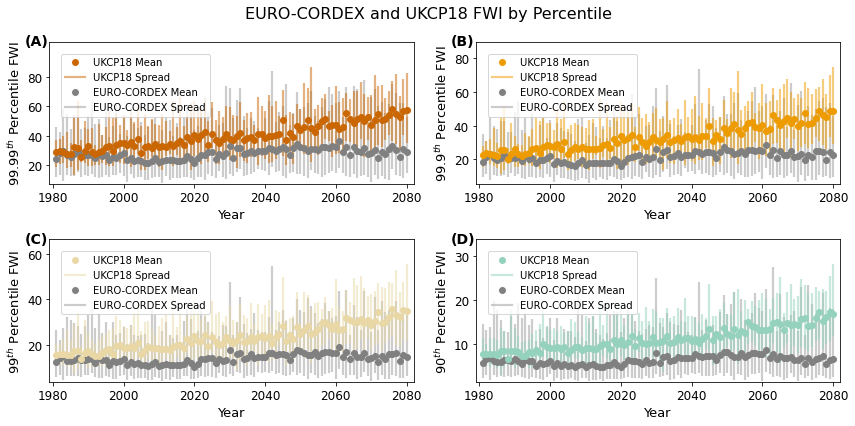

In [9]:
colours =['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
dates = np.array([1981 + i for i in range(100)])
fig,axs = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(12)
fig.suptitle('EURO-CORDEX and UKCP18 FWI by Percentile',fontsize=16)

j = 0
k = 4
cordex_data = np.load('/home/theo/outdata/2.4.outdata/fwi_cordex_data.npy')[:,j,:,k]
ukcp18_data = np.load('/home/theo/outdata/2.4.outdata/fwi_ukcp18_data.npy')[:,j,:,k]
# Plotting CORDEX:
axs[0,0].plot(dates, np.nanmean(cordex_data,axis = 0),'o', color='grey')
axs[0,0].errorbar(dates, np.nanmean(cordex_data,axis = 0),
             yerr=np.stack((np.nanmean(cordex_data,axis = 0) - np.nanmin(cordex_data,axis = 0),
                            np.nanmax(cordex_data,axis = 0) - np.nanmean(cordex_data,axis = 0))), 
             fmt='', color='grey', ecolor='grey', alpha=0.4,
             elinewidth=2.2, capsize=0,ls='none')
axs[0,0].set_ylabel('99.99$^{th}$ Percentile FWI',fontsize=13)
axs[0,0].set_xlabel('Year',fontsize=13)
axs[0,0].tick_params(axis='both', which='major', labelsize=12)
axs[0,0].margins(x=0.02)
axs[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[0,0].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
# Plotting UKCP18:
axs[0,0].plot(dates, np.nanmean(ukcp18_data,axis = 0),'o', color=colours[k])
axs[0,0].errorbar(dates, np.nanmean(ukcp18_data,axis = 0),
             yerr=np.stack((np.nanmean(ukcp18_data,axis = 0) - np.nanmin(ukcp18_data,axis = 0),
                            np.nanmax(ukcp18_data,axis = 0) - np.nanmean(ukcp18_data,axis = 0))), 
             fmt='', color=colours[k], ecolor=colours[k], alpha=0.5,
             elinewidth=2.2, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
           mpl.lines.Line2D([0], [0], color=colours[k], linewidth=2.2, linestyle='-',alpha=0.5),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=2.2, linestyle='-',alpha=0.4)]
axs[0,0].legend(handles,['UKCP18 Mean','UKCP18 Spread','EURO-CORDEX Mean','EURO-CORDEX Spread'],
          loc=2,borderaxespad=1.2)
axs[0,0].tick_params(axis='both', which='major', labelsize=12)
axs[0,0].margins(x=0.02)
axs[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[0,0].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
minbit = 0.9*min(np.min(cordex_data),np.min(ukcp18_data))
spread = 1.1*max(np.max(cordex_data),np.max(ukcp18_data)) - minbit
axs[0,0].text(1972,minbit+spread*1.07, '(A)', size=14,weight='bold')
axs[0,0].set_yticks([20, 40, 60, 80])



j = 0
k = 3
cordex_data = np.load('/home/theo/outdata/2.4.outdata/fwi_cordex_data.npy')[:,j,:,k]
ukcp18_data = np.load('/home/theo/outdata/2.4.outdata/fwi_ukcp18_data.npy')[:,j,:,k]
# Plotting CORDEX:
axs[0,1].plot(dates, np.nanmean(cordex_data,axis = 0),'o', color='grey')
axs[0,1].errorbar(dates, np.nanmean(cordex_data,axis = 0),
             yerr=np.stack((np.nanmean(cordex_data,axis = 0) - np.nanmin(cordex_data,axis = 0),
                            np.nanmax(cordex_data,axis = 0) - np.nanmean(cordex_data,axis = 0))), 
             fmt='', color='grey', ecolor='grey', alpha=0.4,
             elinewidth=2.2, capsize=0,ls='none')
axs[0,1].set_ylabel('99.9$^{th}$ Percentile FWI',fontsize=13)
axs[0,1].set_xlabel('Year',fontsize=13)
axs[0,1].tick_params(axis='both', which='major', labelsize=12)
axs[0,1].margins(x=0.02)
axs[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[0,1].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
# Plotting UKCP18:
axs[0,1].plot(dates, np.nanmean(ukcp18_data,axis = 0),'o', color=colours[k])
axs[0,1].errorbar(dates, np.nanmean(ukcp18_data,axis = 0),
             yerr=np.stack((np.nanmean(ukcp18_data,axis = 0) - np.nanmin(ukcp18_data,axis = 0),
                            np.nanmax(ukcp18_data,axis = 0) - np.nanmean(ukcp18_data,axis = 0))), 
             fmt='', color=colours[k], ecolor=colours[k], alpha=0.5,
             elinewidth=2.2, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
           mpl.lines.Line2D([0], [0], color=colours[k], linewidth=2.2, linestyle='-',alpha=0.5),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=2.2, linestyle='-',alpha=0.4)]
axs[0,1].legend(handles,['UKCP18 Mean','UKCP18 Spread','EURO-CORDEX Mean','EURO-CORDEX Spread'],
          loc=2,borderaxespad=1.2)
axs[0,1].tick_params(axis='both', which='major', labelsize=12)
axs[0,1].margins(x=0.02)
axs[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[0,1].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
minbit = 0.9*min(np.min(cordex_data),np.min(ukcp18_data))
spread = 1.1*max(np.max(cordex_data),np.max(ukcp18_data)) - minbit
axs[0,1].text(1972,minbit+spread*1.07, '(B)', size=14,weight='bold')


j = 0
k = 2
cordex_data = np.load('/home/theo/outdata/2.4.outdata/fwi_cordex_data.npy')[:,j,:,k]
ukcp18_data = np.load('/home/theo/outdata/2.4.outdata/fwi_ukcp18_data.npy')[:,j,:,k]
# Plotting CORDEX:
axs[1,0].plot(dates, np.nanmean(cordex_data,axis = 0),'o', color='grey')
axs[1,0].errorbar(dates, np.nanmean(cordex_data,axis = 0),
             yerr=np.stack((np.nanmean(cordex_data,axis = 0) - np.nanmin(cordex_data,axis = 0),
                            np.nanmax(cordex_data,axis = 0) - np.nanmean(cordex_data,axis = 0))), 
             fmt='', color='grey', ecolor='grey', alpha=0.4,
             elinewidth=2.2, capsize=0,ls='none')
axs[1,0].set_ylabel('99$^{th}$ Percentile FWI',fontsize=13)
axs[1,0].set_xlabel('Year',fontsize=13)
axs[1,0].tick_params(axis='both', which='major', labelsize=12)
axs[1,0].margins(x=0.02)
axs[1,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[1,0].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
# Plotting UKCP18:
axs[1,0].plot(dates, np.nanmean(ukcp18_data,axis = 0),'o', color=colours[k])
axs[1,0].errorbar(dates, np.nanmean(ukcp18_data,axis = 0),
             yerr=np.stack((np.nanmean(ukcp18_data,axis = 0) - np.nanmin(ukcp18_data,axis = 0),
                            np.nanmax(ukcp18_data,axis = 0) - np.nanmean(ukcp18_data,axis = 0))), 
             fmt='', color=colours[k], ecolor=colours[k], alpha=0.5,
             elinewidth=2.2, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
           mpl.lines.Line2D([0], [0], color=colours[k], linewidth=2.2, linestyle='-',alpha=0.5),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=2.2, linestyle='-',alpha=0.4)]
axs[1,0].legend(handles,['UKCP18 Mean','UKCP18 Spread','EURO-CORDEX Mean','EURO-CORDEX Spread'],
          loc=2,borderaxespad=1.2)
axs[1,0].tick_params(axis='both', which='major', labelsize=12)
axs[1,0].margins(x=0.02)
axs[1,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[1,0].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
minbit = 0.9*min(np.min(cordex_data),np.min(ukcp18_data))
spread = 1.1*max(np.max(cordex_data),np.max(ukcp18_data)) - minbit
axs[1,0].text(1972,minbit+spread*1.07, '(C)', size=14,weight='bold')



j = 0
k = 1
cordex_data = np.load('/home/theo/outdata/2.4.outdata/fwi_cordex_data.npy')[:,j,:,k]
ukcp18_data = np.load('/home/theo/outdata/2.4.outdata/fwi_ukcp18_data.npy')[:,j,:,k]
# Plotting CORDEX:
axs[1,1].plot(dates, np.nanmean(cordex_data,axis = 0),'o', color='grey')
axs[1,1].errorbar(dates, np.nanmean(cordex_data,axis = 0),
             yerr=np.stack((np.nanmean(cordex_data,axis = 0) - np.nanmin(cordex_data,axis = 0),
                            np.nanmax(cordex_data,axis = 0) - np.nanmean(cordex_data,axis = 0))), 
             fmt='', color='grey', ecolor='grey', alpha=0.4,
             elinewidth=2.2, capsize=0,ls='none')
axs[1,1].set_ylabel('90$^{th}$ Percentile FWI',fontsize=13)
axs[1,1].set_xlabel('Year',fontsize=13)
axs[1,1].tick_params(axis='both', which='major', labelsize=12)
axs[1,1].margins(x=0.02)
axs[1,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[1,1].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
# Plotting UKCP18:
axs[1,1].plot(dates, np.nanmean(ukcp18_data,axis = 0),'o', color=colours[k])
axs[1,1].errorbar(dates, np.nanmean(ukcp18_data,axis = 0),
             yerr=np.stack((np.nanmean(ukcp18_data,axis = 0) - np.nanmin(ukcp18_data,axis = 0),
                            np.nanmax(ukcp18_data,axis = 0) - np.nanmean(ukcp18_data,axis = 0))), 
             fmt='', color=colours[k], ecolor=colours[k], alpha=0.5,
             elinewidth=2.2, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
           mpl.lines.Line2D([0], [0], color=colours[k], linewidth=2.2, linestyle='-',alpha=0.5),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=2.2, linestyle='-',alpha=0.4)]
axs[1,1].legend(handles,['UKCP18 Mean','UKCP18 Spread','EURO-CORDEX Mean','EURO-CORDEX Spread'],
          loc=2,borderaxespad=1.2)
axs[1,1].tick_params(axis='both', which='major', labelsize=12)
axs[1,1].margins(x=0.02)
axs[1,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
axs[1,1].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.2*max(np.max(cordex_data),np.max(ukcp18_data)))
minbit = 0.9*min(np.min(cordex_data),np.min(ukcp18_data))
spread = 1.1*max(np.max(cordex_data),np.max(ukcp18_data)) - minbit
axs[1,1].text(1972,minbit+spread*1.07, '(D)', size=14,weight='bold')
        
plt.tight_layout()
plt.savefig('/home/theo/final_images/2.4.images/_combo_plot')

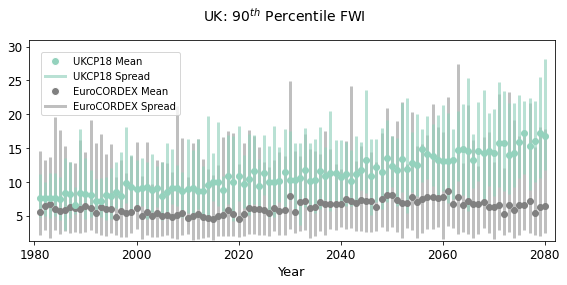

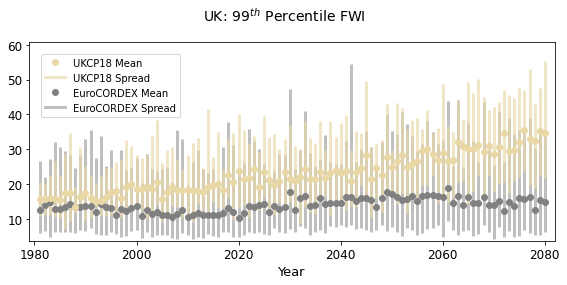

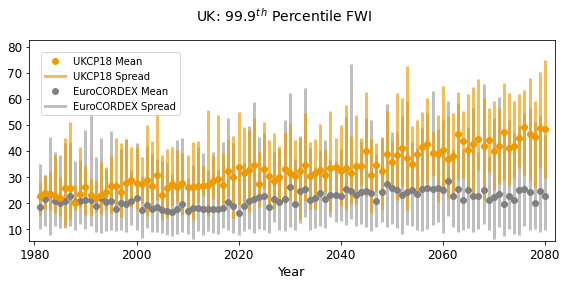

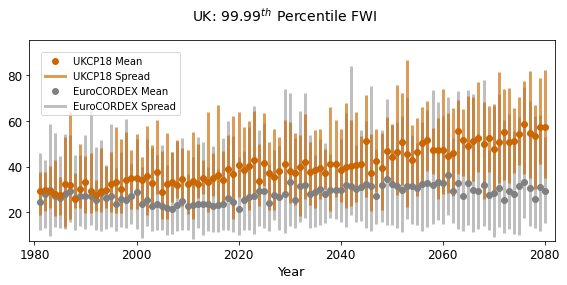

In [7]:
colours =['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
savelbls=['50_pctl','90_pctl','99_pctl','99_9_pctl','99_99_pctl',]
labels = ['50$^t$$^h$ Percentile','90$^t$$^h$ Percentile','99$^t$$^h$ Percentile',
          '99.9$^t$$^h$ Percentile','99.99$^t$$^h$ Percentile']
j = 0
# Loading data:
for k in range(1,5):
    cordex_data = np.load('/home/theo/outdata/2.4.outdata/fwi_cordex_data.npy')[:,j,:,k]
    ukcp18_data = np.load('/home/theo/outdata/2.4.outdata/fwi_ukcp18_data.npy')[:,j,:,k]

    # Making dates:
    dates = np.array([1981 + i for i in range(100)])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        fig,ax = plt.subplots(1)
        fig.set_figheight(4)
        fig.set_figwidth(8)
        fig.suptitle(f'{ids[j]}: {labels[k]} FWI',fontsize=14)

        # Plotting CORDEX:
        ax.plot(dates, np.nanmean(cordex_data,axis = 0),'o', color='grey')
        ax.errorbar(dates, np.nanmean(cordex_data,axis = 0),
                     yerr=np.stack((np.nanmean(cordex_data,axis = 0) - np.nanmin(cordex_data,axis = 0),
                                    np.nanmax(cordex_data,axis = 0) - np.nanmean(cordex_data,axis = 0))), 
                     fmt='', color='grey', ecolor='grey', alpha=0.5,
                     elinewidth=3, capsize=0,ls='none')
        handles = []
        ax.legend(handles,['Ensemble Mean','Ensemble Spread'],loc=2,borderaxespad=1.2)
        ax.set_xlabel('Year',fontsize=13)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.margins(x=0.02)
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
        ax.set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))

        # Plotting UKCP18:
        ax.plot(dates, np.nanmean(ukcp18_data,axis = 0),'o', color=colours[k])
        ax.errorbar(dates, np.nanmean(ukcp18_data,axis = 0),
                     yerr=np.stack((np.nanmean(ukcp18_data,axis = 0) - np.nanmin(ukcp18_data,axis = 0),
                                    np.nanmax(ukcp18_data,axis = 0) - np.nanmean(ukcp18_data,axis = 0))), 
                     fmt='', color=colours[k], ecolor=colours[k], alpha=0.65,
                     elinewidth=3, capsize=0,ls='none')
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
                   mpl.lines.Line2D([0], [0], color=colours[k], linewidth=3, linestyle='-',alpha=0.65),
                   mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
                   mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
        ax.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
                  loc=2,borderaxespad=1.2)
        ax.set_xlabel('Year',fontsize=13)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.margins(x=0.02)
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
        ax.set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))
        plt.tight_layout()
plt.savefig(f'/home/theo/final_images/2.4.images/_FWI_comparison_grid')

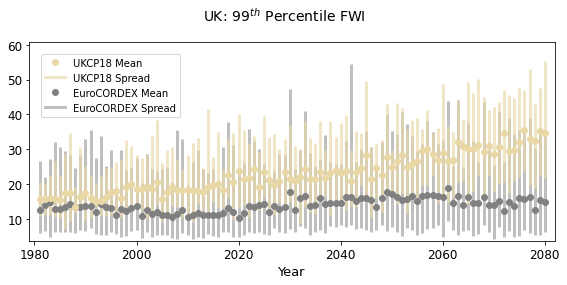

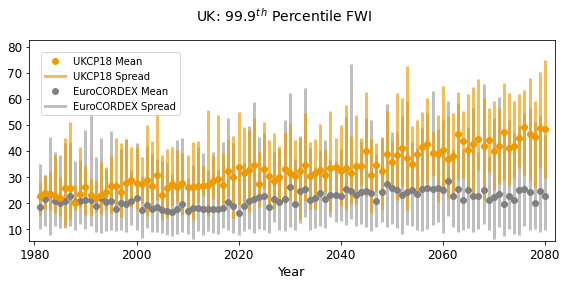

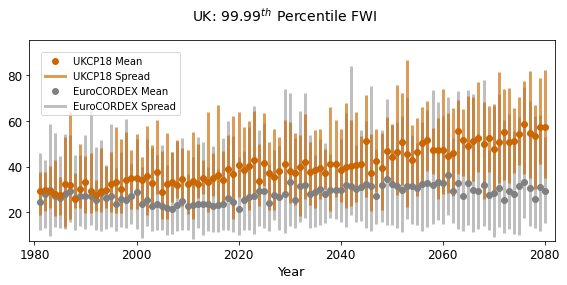

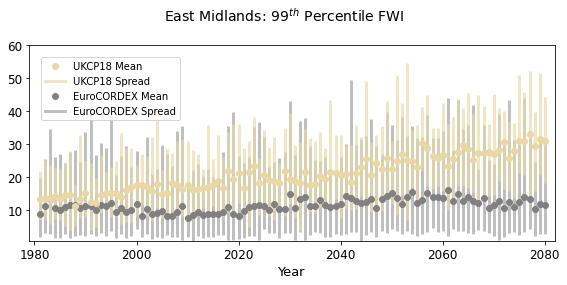

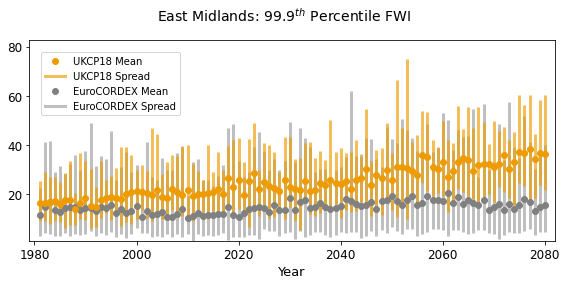

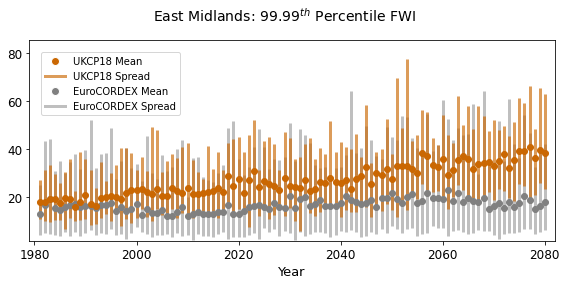

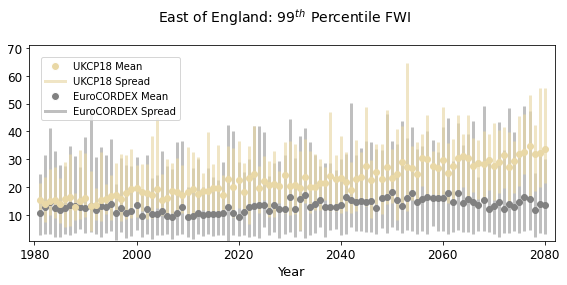

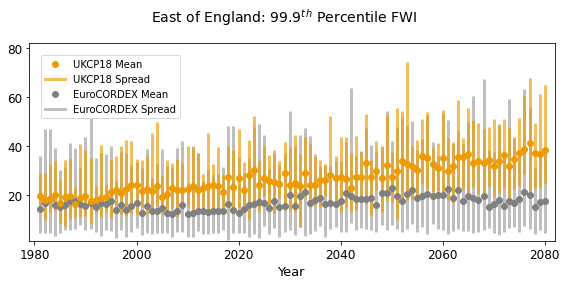

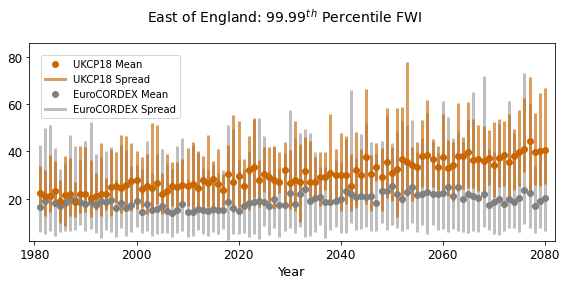

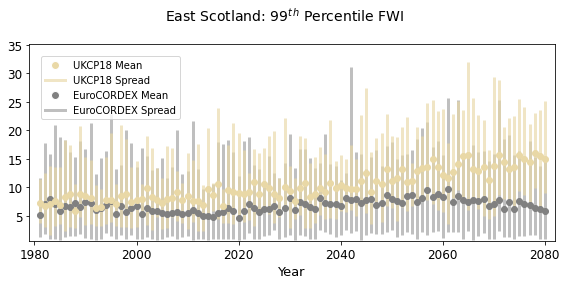

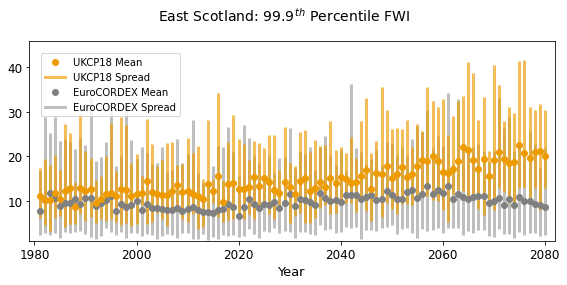

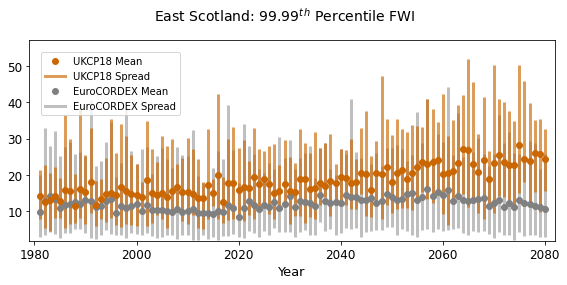

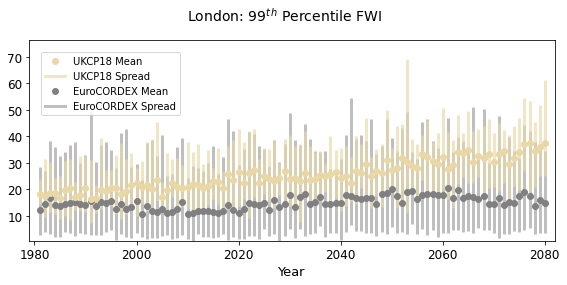

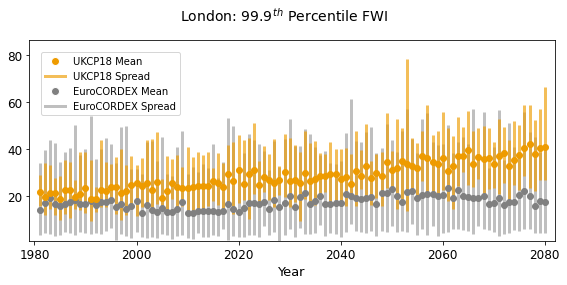

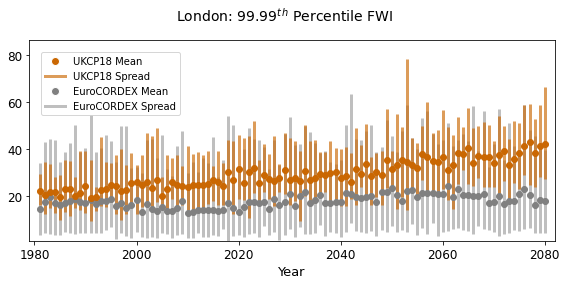

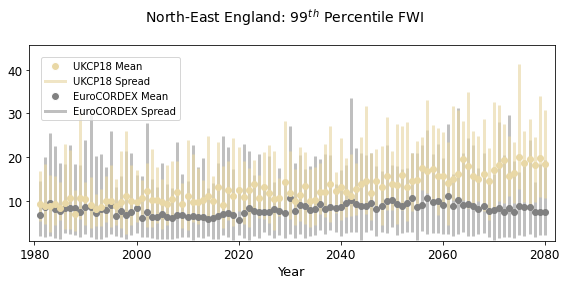

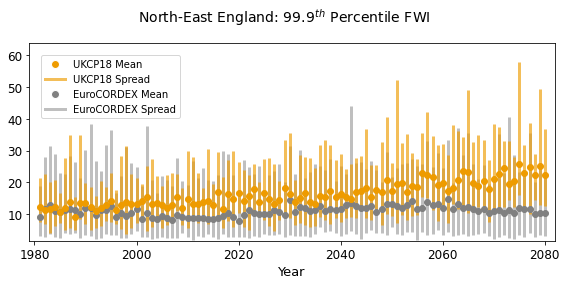

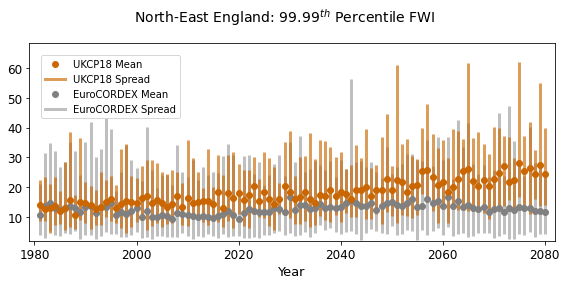

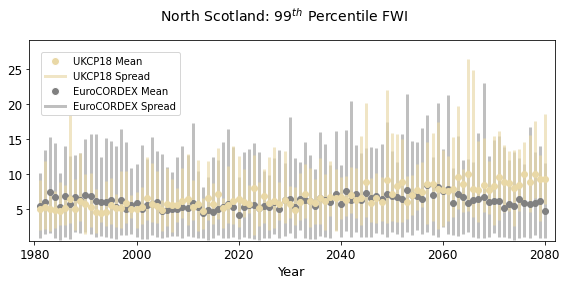

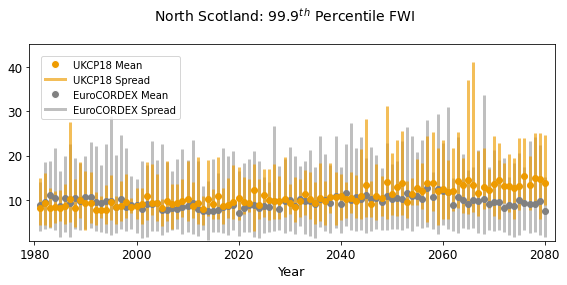

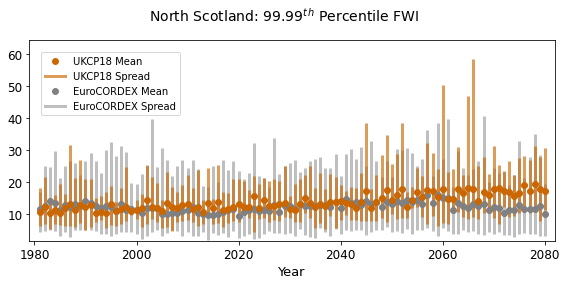

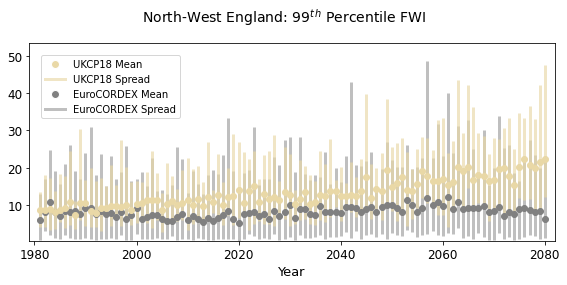

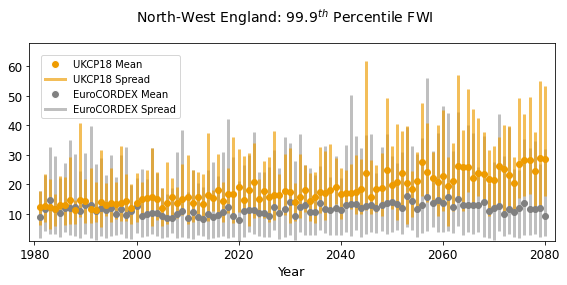

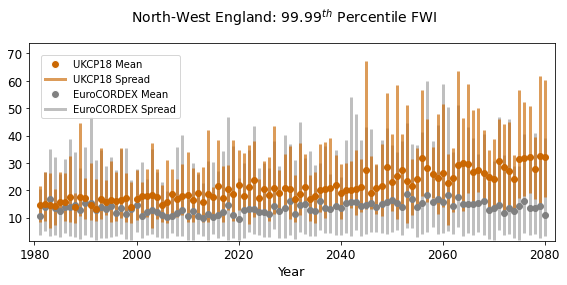

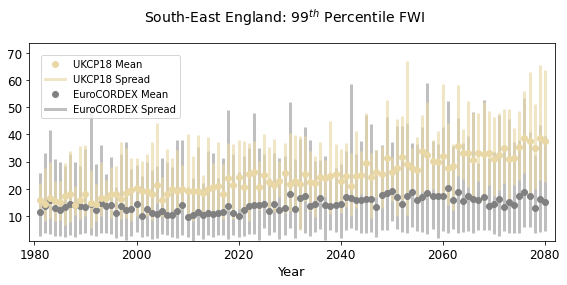

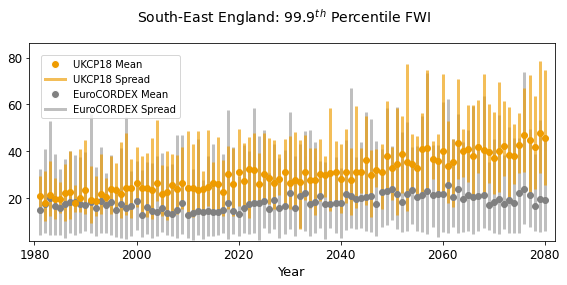

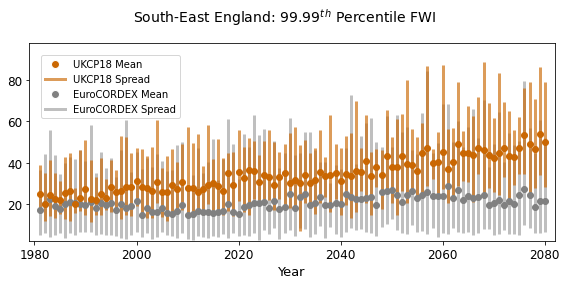

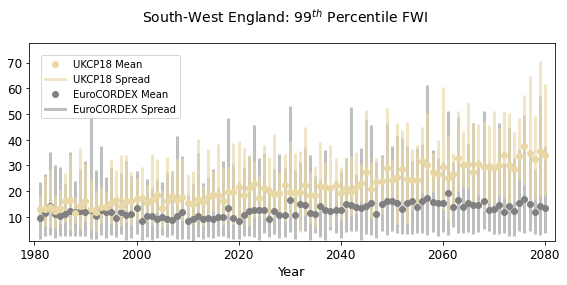

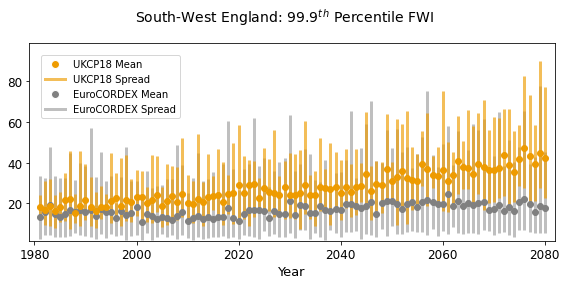

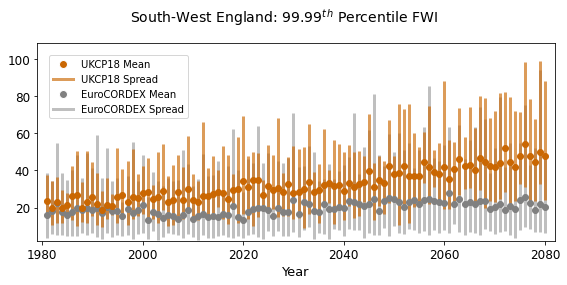

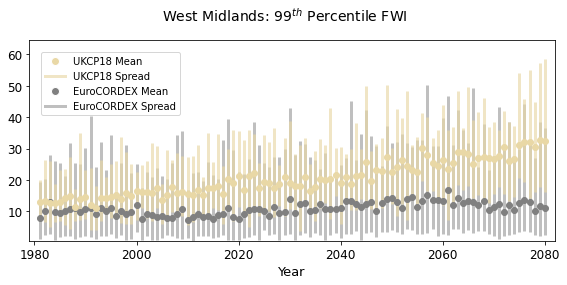

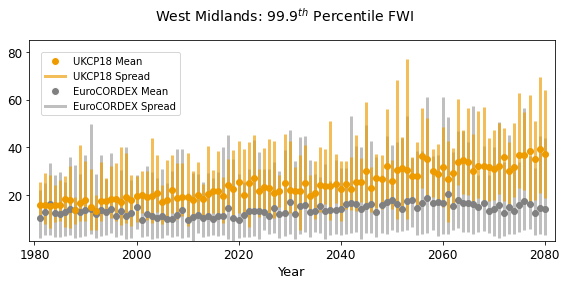

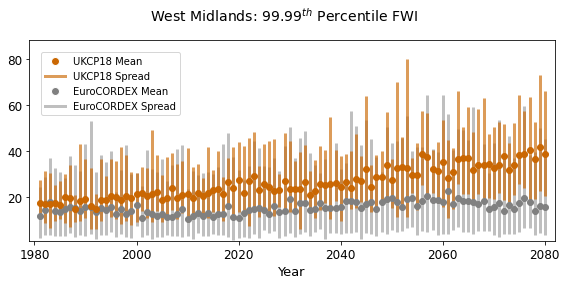

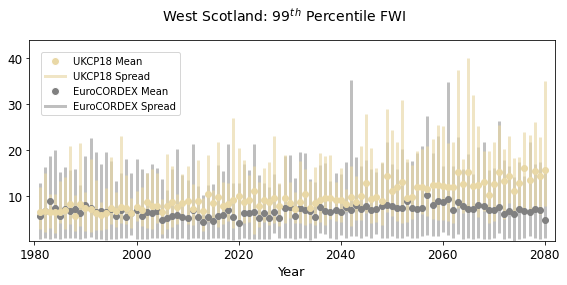

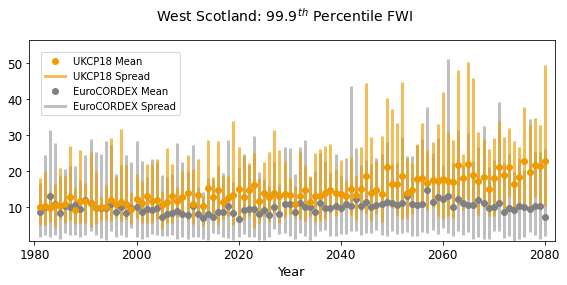

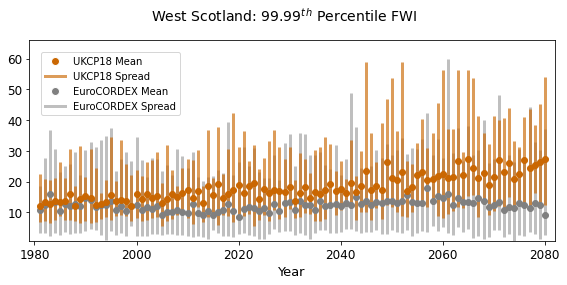

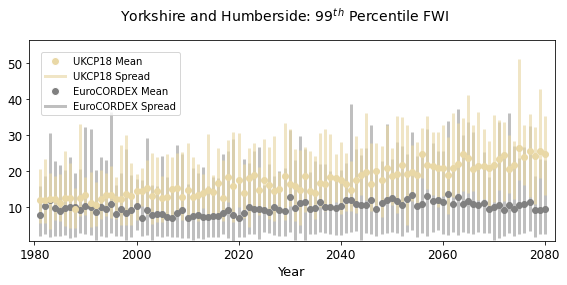

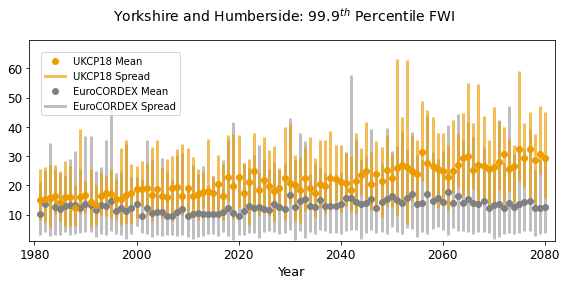

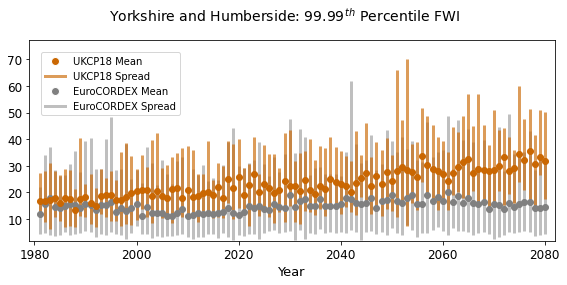

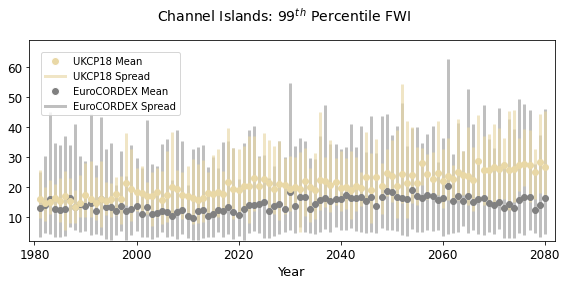

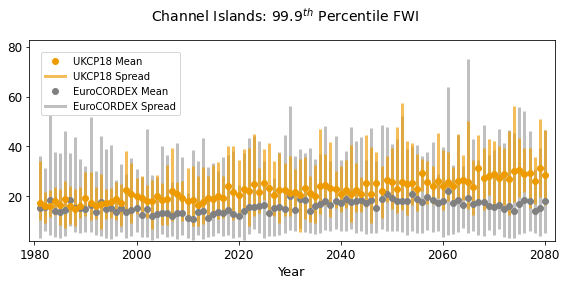

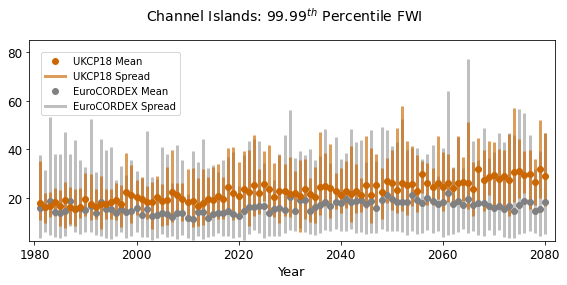

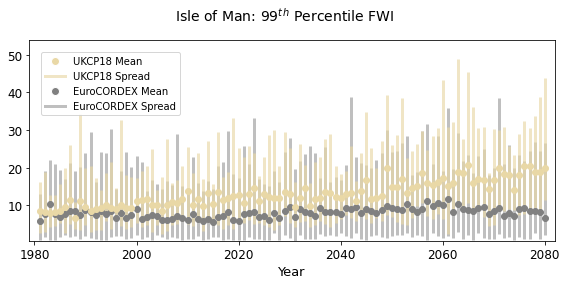

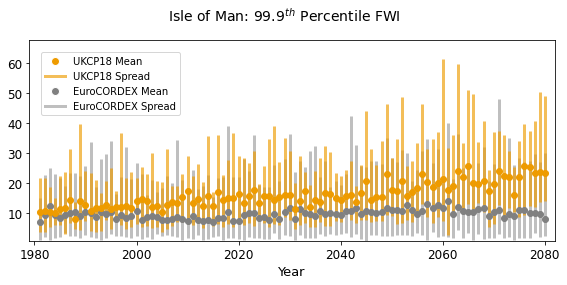

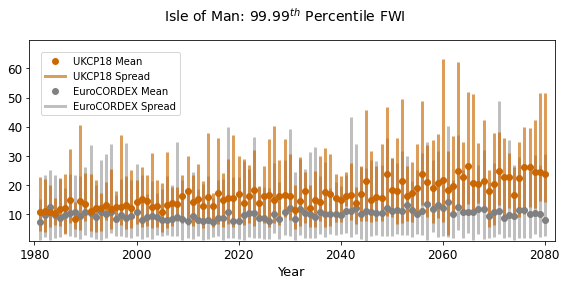

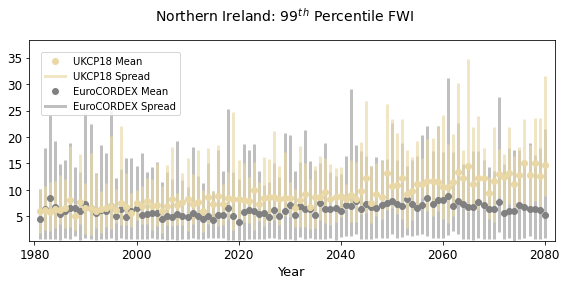

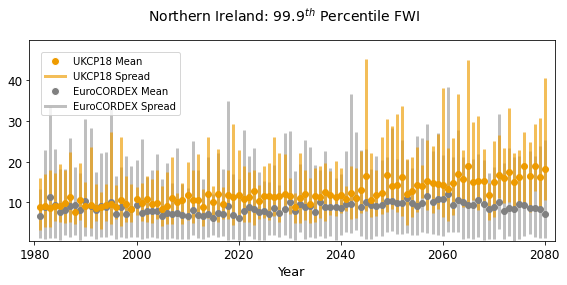

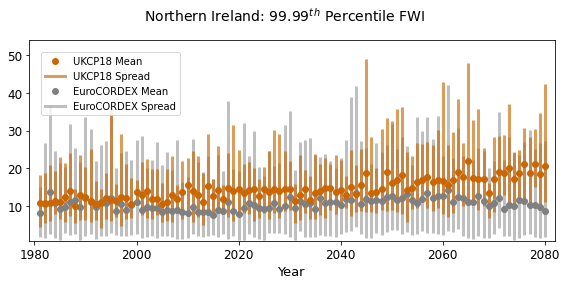

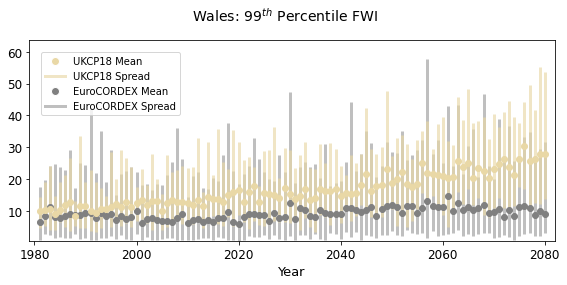

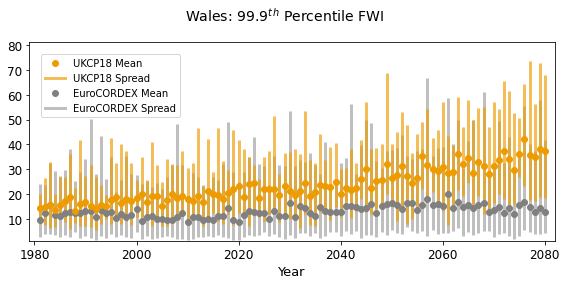

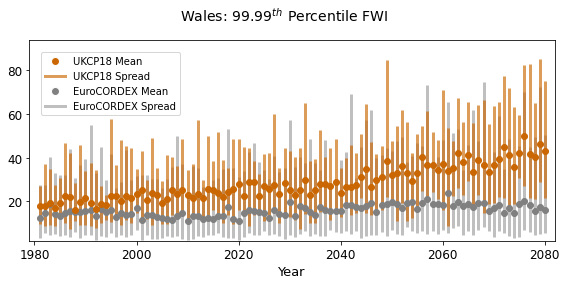

In [17]:
colours =['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
savelbls=['50_pctl','90_pctl','99_pctl','99_9_pctl','99_99_pctl',]
labels = ['50$^t$$^h$ Percentile','90$^t$$^h$ Percentile','99$^t$$^h$ Percentile',
          '99.9$^t$$^h$ Percentile','99.99$^t$$^h$ Percentile']
for j in range(17):
    # Loading data:
    for k in range(2,5):
        cordex_data = np.load('/home/theo/outdata/2.4.outdata/fwi_cordex_data.npy')[:,j,:,k]
        ukcp18_data = np.load('/home/theo/outdata/2.4.outdata/fwi_ukcp18_data.npy')[:,j,:,k]

        # Making dates:
        dates = np.array([1981 + i for i in range(100)])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            fig,ax = plt.subplots(1)
            fig.set_figheight(4)
            fig.set_figwidth(8)
            fig.suptitle(f'{ids[j]}: {labels[k]} FWI',fontsize=14)

            
            # Plotting CORDEX:
            ax.plot(dates, np.nanmean(cordex_data,axis = 0),'o', color='grey')
            ax.errorbar(dates, np.nanmean(cordex_data,axis = 0),
                         yerr=np.stack((np.nanmean(cordex_data,axis = 0) - np.nanmin(cordex_data,axis = 0),
                                        np.nanmax(cordex_data,axis = 0) - np.nanmean(cordex_data,axis = 0))), 
                         fmt='', color='grey', ecolor='grey', alpha=0.5,
                         elinewidth=3, capsize=0,ls='none')
            handles = []
            ax.legend(handles,['Ensemble Mean','Ensemble Spread'],loc=2,borderaxespad=1.2)
            ax.set_xlabel('Year',fontsize=13)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.margins(x=0.02)
            ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
            ax.set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))
            
            

            # Plotting UKCP18:
            ax.plot(dates, np.nanmean(ukcp18_data,axis = 0),'o', color=colours[k])
            ax.errorbar(dates, np.nanmean(ukcp18_data,axis = 0),
                         yerr=np.stack((np.nanmean(ukcp18_data,axis = 0) - np.nanmin(ukcp18_data,axis = 0),
                                        np.nanmax(ukcp18_data,axis = 0) - np.nanmean(ukcp18_data,axis = 0))), 
                         fmt='', color=colours[k], ecolor=colours[k], alpha=0.65,
                         elinewidth=3, capsize=0,ls='none')
            handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
                       mpl.lines.Line2D([0], [0], color=colours[k], linewidth=3, linestyle='-',alpha=0.65),
                       mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
                       mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
            ax.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
                      loc=2,borderaxespad=1.2)
            ax.set_xlabel('Year',fontsize=13)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.margins(x=0.02)
            ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
            ax.set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))
            plt.tight_layout()
            plt.savefig(f'/home/theo/final_images/2.4.images/{savelbls[k]}_{save_ids[j]}')

#### DSR: 

In [4]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
dates = np.array([1981 + i for i in range(100)])
dsr_cordex_data = np.empty((48,17,100,5))
for i in range(48):
    print(f'Step {i+1} of 48')
    fwi = np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+2}.npy')
    dsr = 0.0272 * fwi ** 1.77
    del fwi
    tas_data  = xarray.open_dataset(directories[i+1] + tas_files[i+1], engine = "netcdf4")
    try:
        years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    del tas_data
    for j in range(17):
        mask = (region_mask == j).astype(int)

        
        for k in range(100):
            summer_indices = np.array([])
            year_inds = np.where(years == 1981+k)
            summer_inds=np.concatenate((np.where(months == 6)[0],
                                        np.where(months == 7)[0],
                                        np.where(months == 8)[0]),
                                        axis = 0)
            summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)
            masked_dsr = np.einsum('ijk,jk->ijk', dsr[0,summer_indices,:,:], mask)
            masked_dsr[masked_dsr == 0] = np.nan
            dsr_cordex_data[i,j,k,0] = np.nanpercentile(masked_dsr,50)
            dsr_cordex_data[i,j,k,1] = np.nanpercentile(masked_dsr,90)
            dsr_cordex_data[i,j,k,2] = np.nanpercentile(masked_dsr,99)
            dsr_cordex_data[i,j,k,3] = np.nanpercentile(masked_dsr,99.9)
            dsr_cordex_data[i,j,k,4] = np.nanpercentile(masked_dsr,99.99)

            del masked_dsr,summer_indices,summer_inds,year_inds
        del mask
    del dsr,years,months
np.save('/home/theo/outdata/2.4.outdata/dsr_cordex_data',dsr_cordex_data)

<class 'list'>
Step 1 of 48
Step 2 of 48
Step 3 of 48
Step 4 of 48
Step 5 of 48
Step 6 of 48
Step 7 of 48
Step 8 of 48
Step 9 of 48
Step 10 of 48
Step 11 of 48
Step 12 of 48
Step 13 of 48
Step 14 of 48
Step 15 of 48
Step 16 of 48
Step 17 of 48
Step 18 of 48
Step 19 of 48
Step 20 of 48
Step 21 of 48
Step 22 of 48
Step 23 of 48
Step 24 of 48
Step 25 of 48
Step 26 of 48
Step 27 of 48
Step 28 of 48
Step 29 of 48
Step 30 of 48
Step 31 of 48
Step 32 of 48
Step 33 of 48
Step 34 of 48
Step 35 of 48
Step 36 of 48
Step 37 of 48
Step 38 of 48
Step 39 of 48
Step 40 of 48
Step 41 of 48
Step 42 of 48
Step 43 of 48
Step 44 of 48
Step 45 of 48
Step 46 of 48
Step 47 of 48
Step 48 of 48


In [5]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
tag = ['01','04','05','06','07','08','09','10','11','12','13','15']
dates = np.array([1981 + i for i in range(100)])
dsr_ukcp_data = np.empty((12,17,100,5))
for i in range(12):
    print(f'Step {i+1} of 12')
    fwi = np.load(f'/data/met/fwi/ukcp18_new_fwi_{tag[i]}.npy')
    dsr = 0.0272 * fwi ** 1.77
    del fwi
    tas_file = f'/data/met/ukcp18/{tag[i]}/dmo/tas_rcp85_ukcp18_natgb_{tag[i]}_day_19801201-20801130.nc'
    tas_data  = xarray.open_dataset(tas_file, engine = "netcdf4")
    try:
        years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    del tas_data,tas_file
    for j in range(17):
        mask = (region_mask == j).astype(int)
        for k in range(100):
            summer_indices = np.array([])
            year_inds = np.where(years == 1981+k)
            summer_inds=np.concatenate((np.where(months == 6)[0],
                                        np.where(months == 7)[0],
                                        np.where(months == 8)[0]),
                                        axis = 0)
            summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)
            masked_dsr = np.einsum('ijk,jk->ijk', dsr[0,summer_indices,:,:], mask)
            masked_dsr[masked_dsr == 0] = np.nan

            dsr_ukcp_data[i,j,k,0] = np.nanpercentile(masked_dsr,50)
            dsr_ukcp_data[i,j,k,1] = np.nanpercentile(masked_dsr,90)
            dsr_ukcp_data[i,j,k,2] = np.nanpercentile(masked_dsr,99)
            dsr_ukcp_data[i,j,k,3] = np.nanpercentile(masked_dsr,99.9)
            dsr_ukcp_data[i,j,k,4] = np.nanpercentile(masked_dsr,99.99)
            del masked_dsr,summer_indices,summer_inds,year_inds
        del mask
    del dsr,years,months
np.save('/home/theo/outdata/2.4.outdata/dsr_ukcp18_data',dsr_ukcp_data)

Step 1 of 12
Step 2 of 12
Step 3 of 12
Step 4 of 12
Step 5 of 12
Step 6 of 12
Step 7 of 12
Step 8 of 12
Step 9 of 12
Step 10 of 12
Step 11 of 12
Step 12 of 12


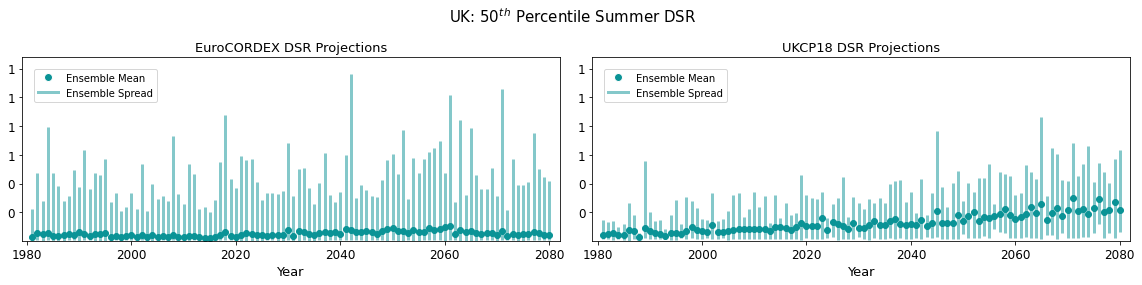

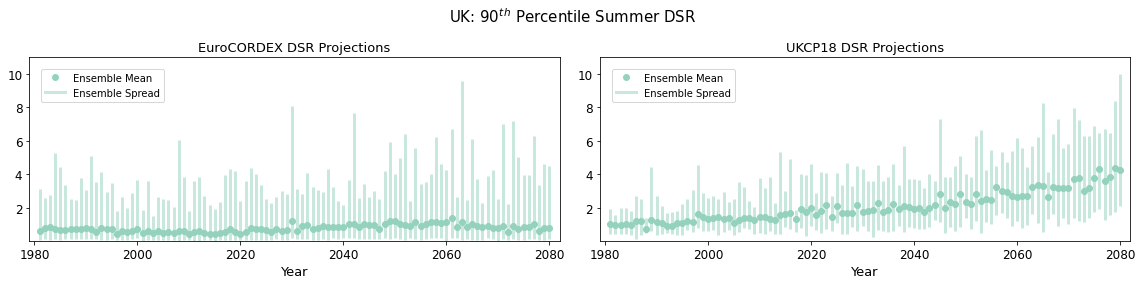

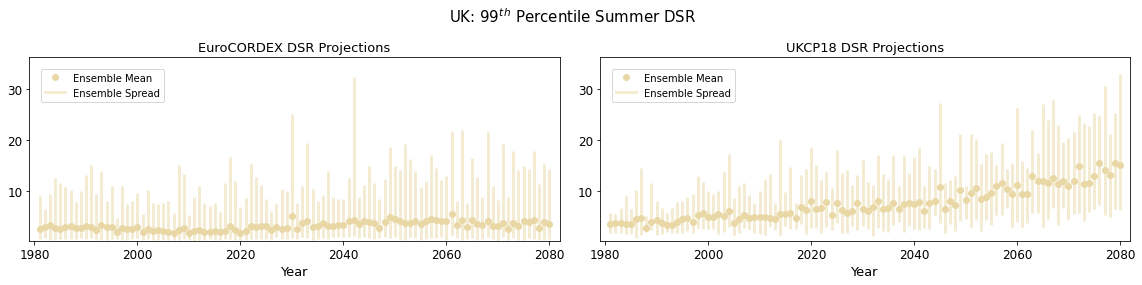

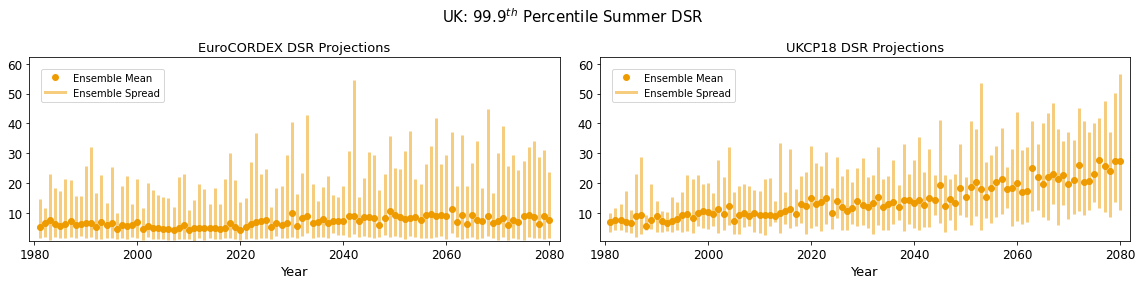

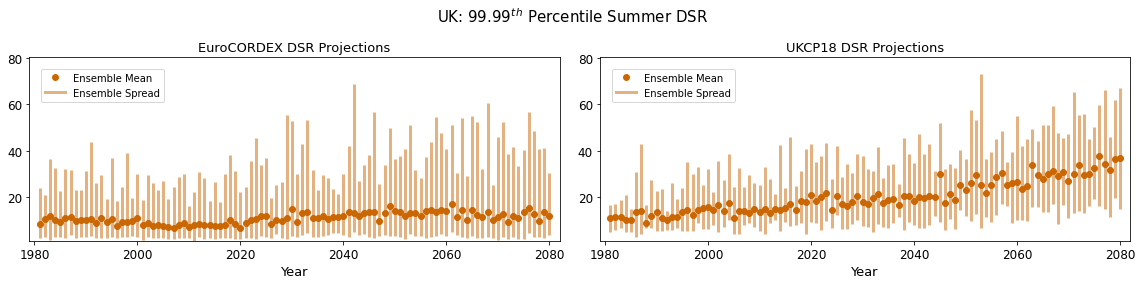

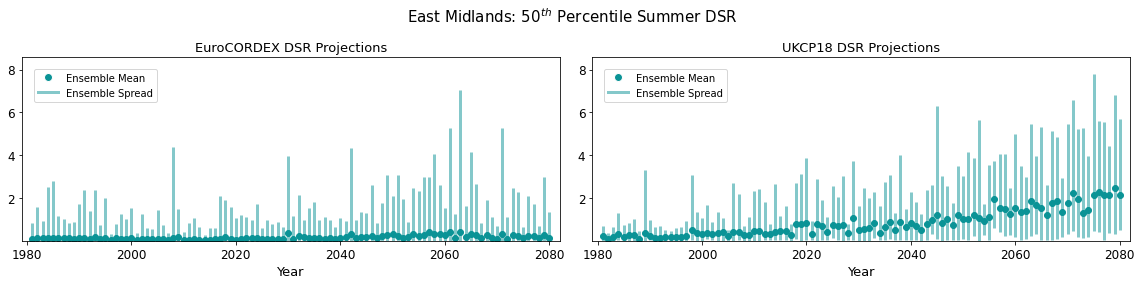

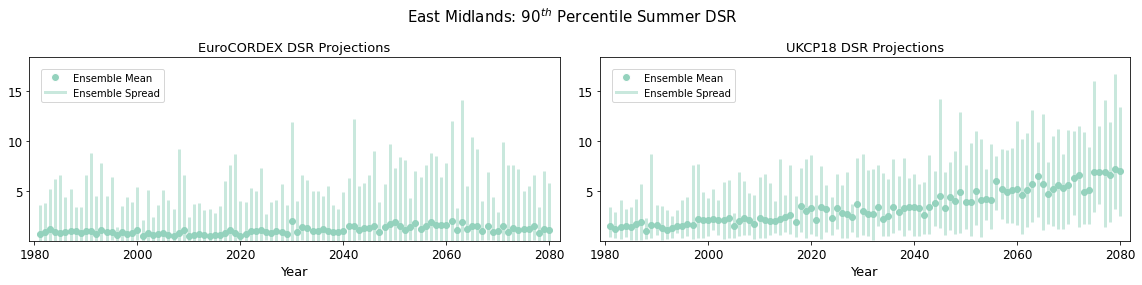

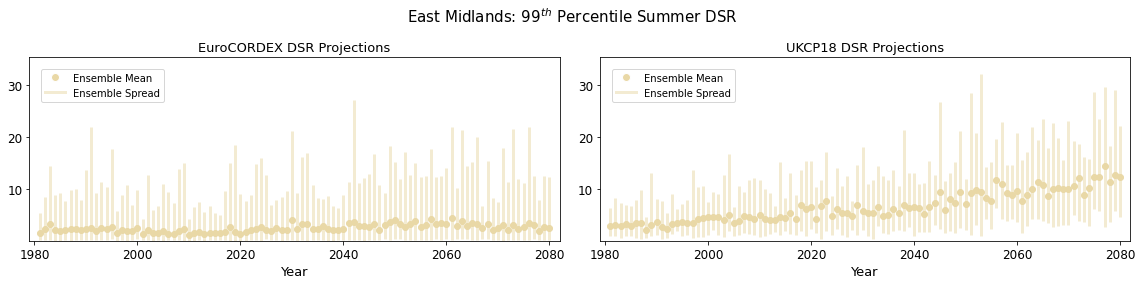

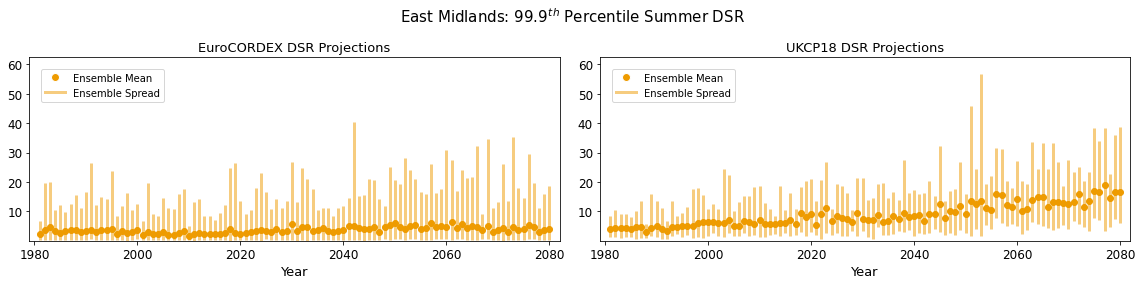

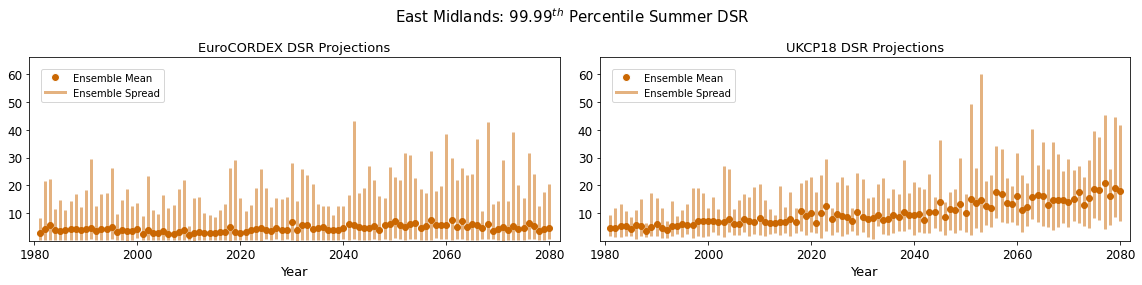

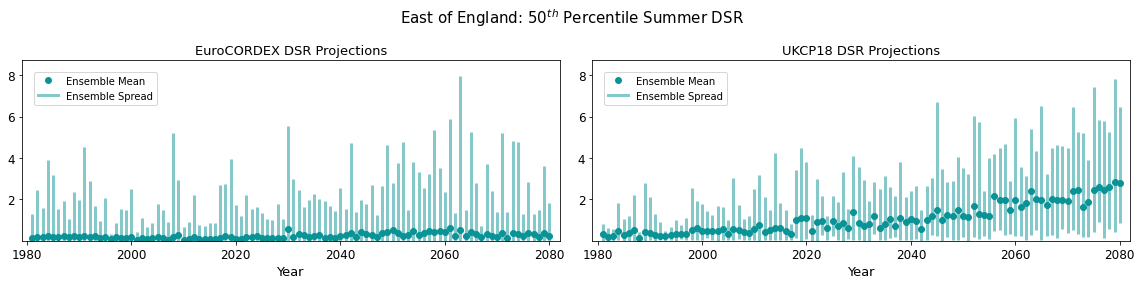

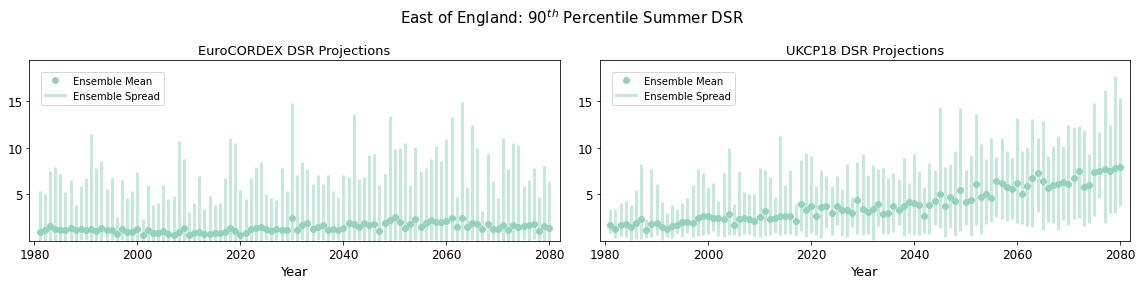

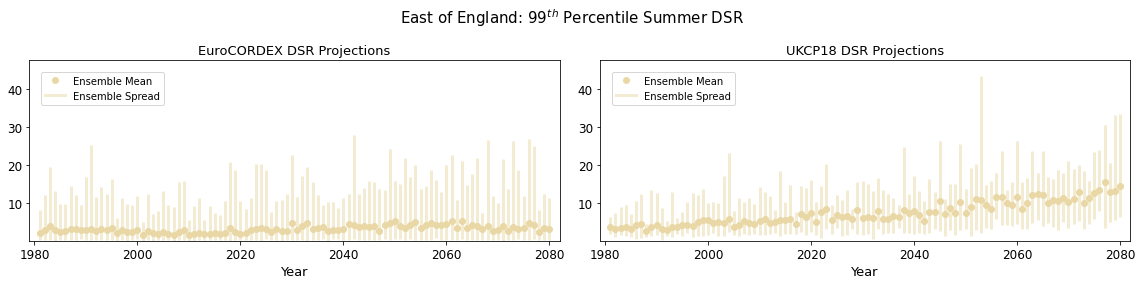

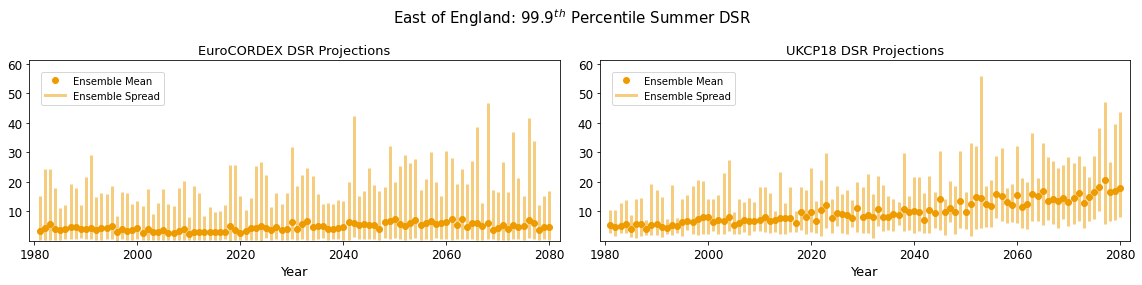

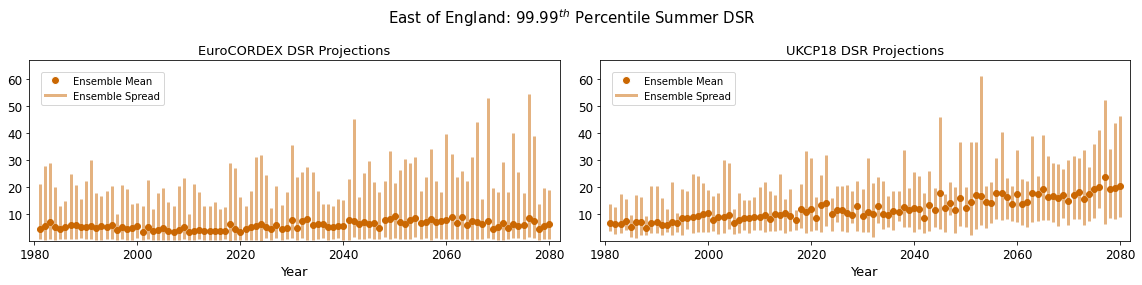

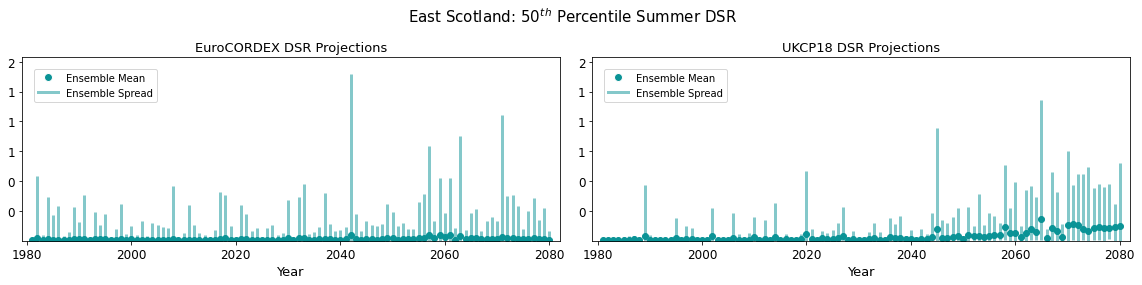

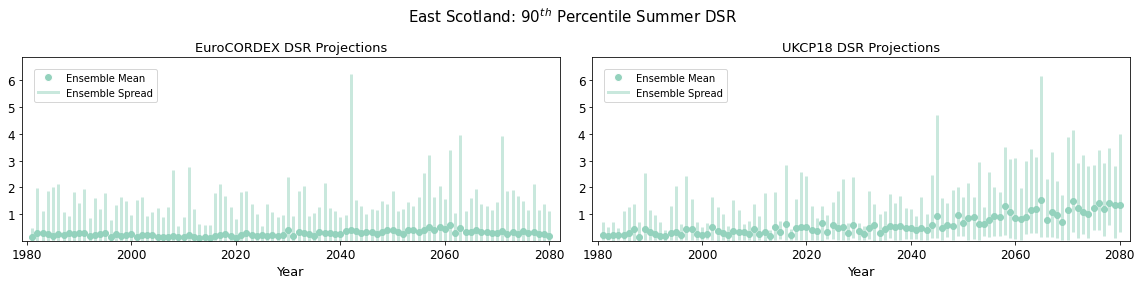

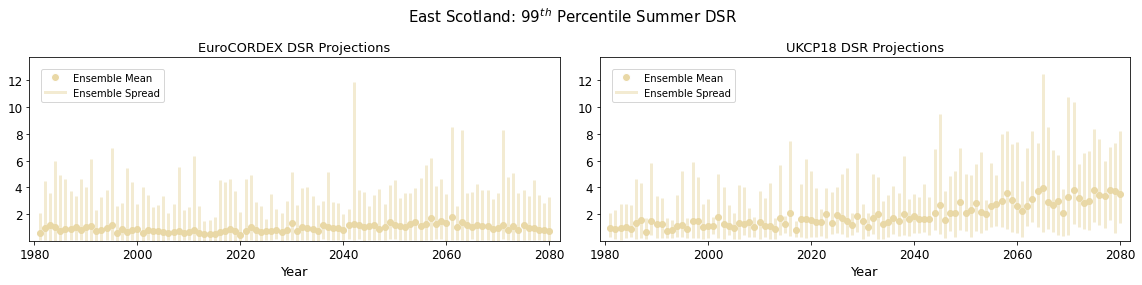

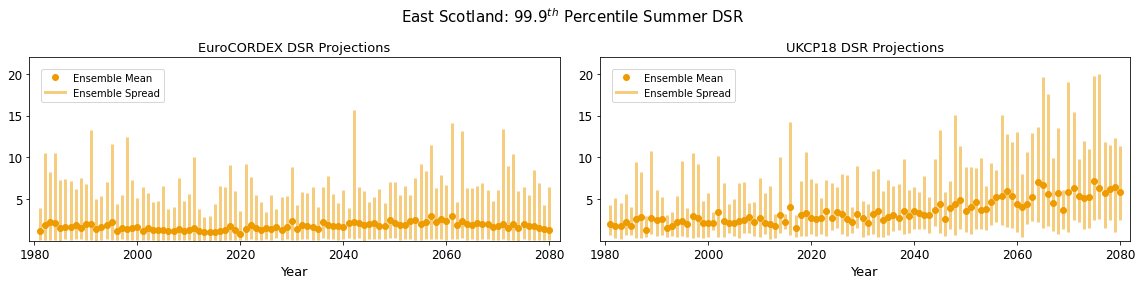

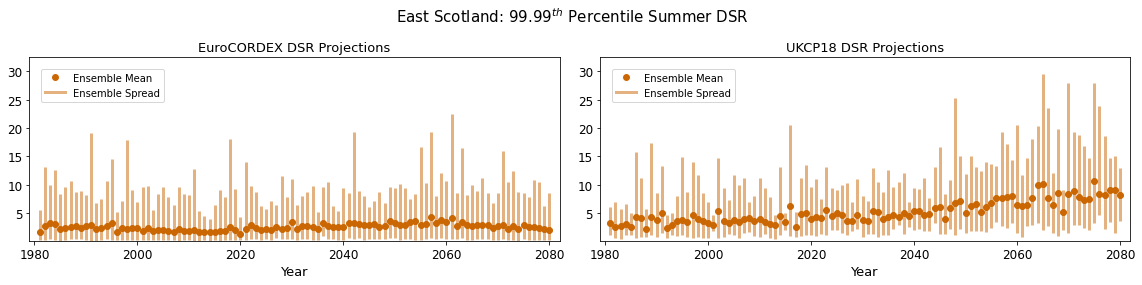

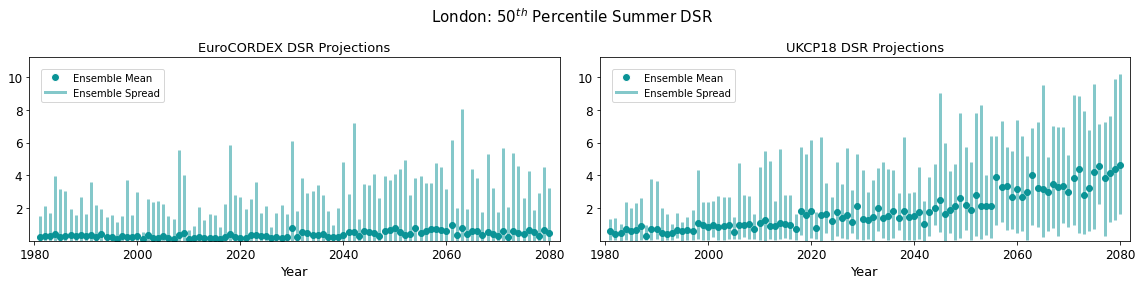

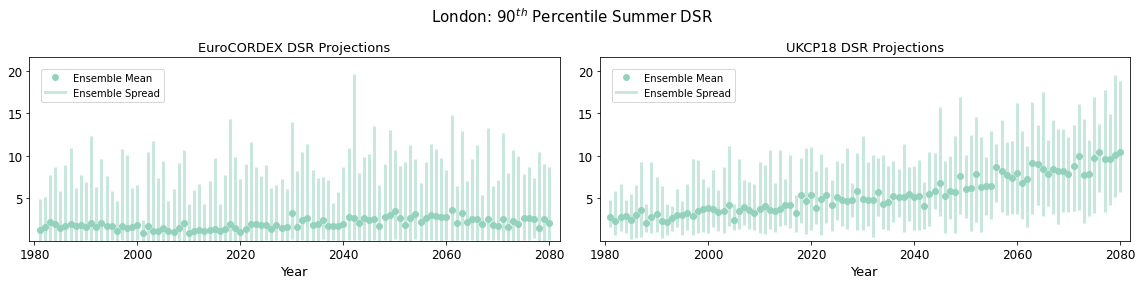

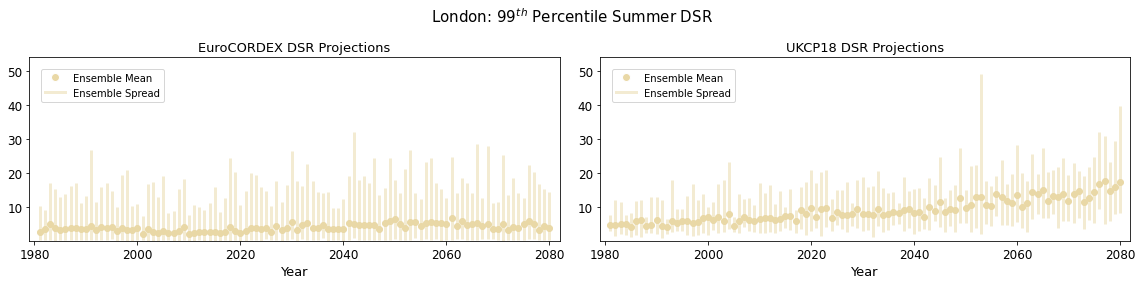

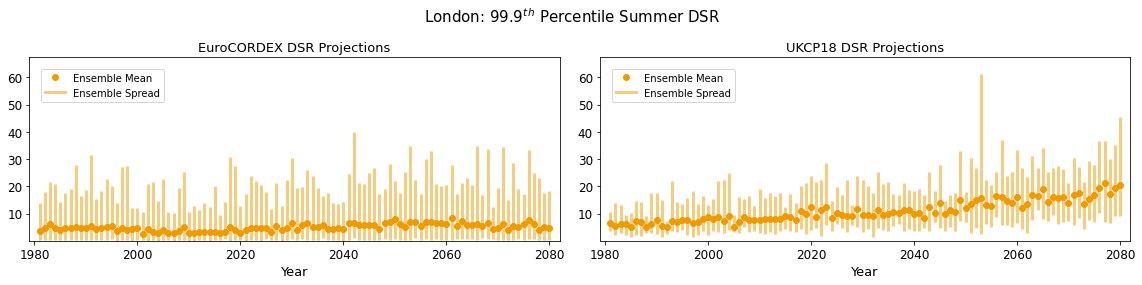

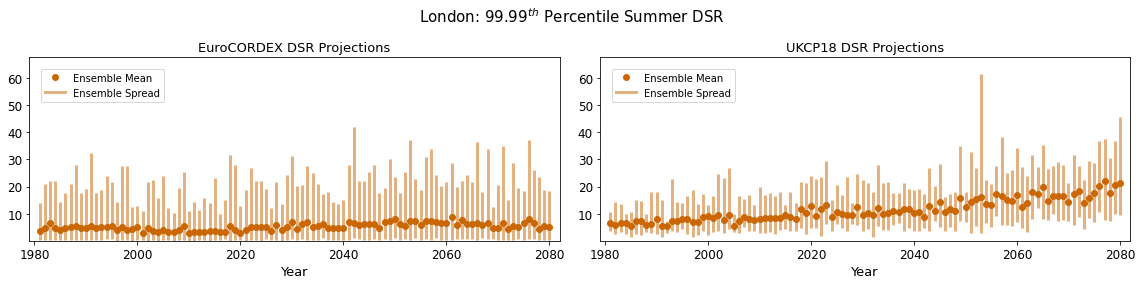

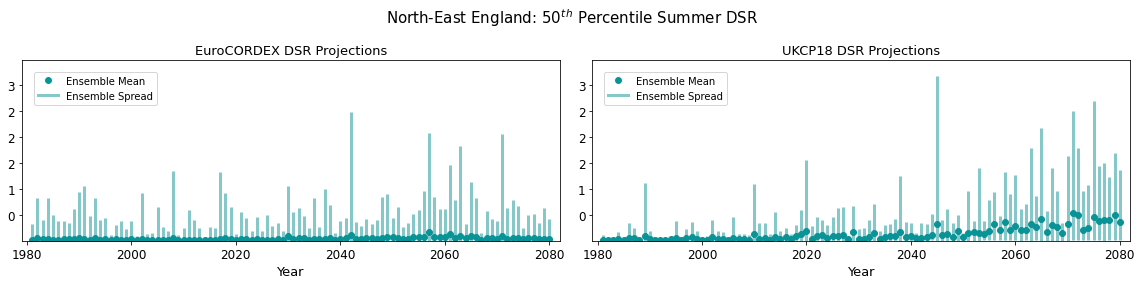

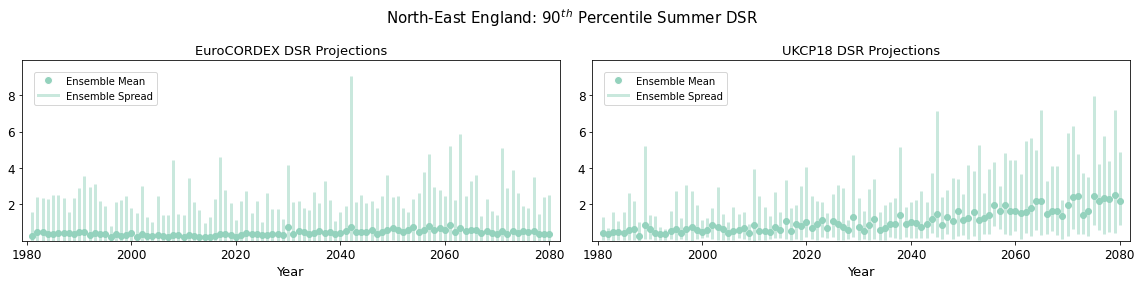

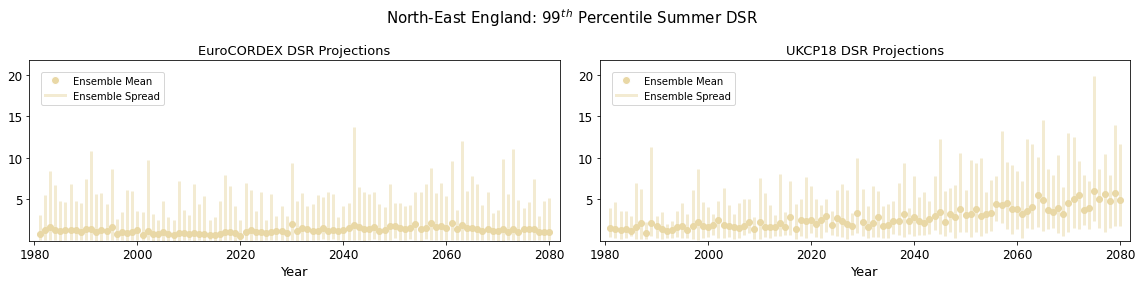

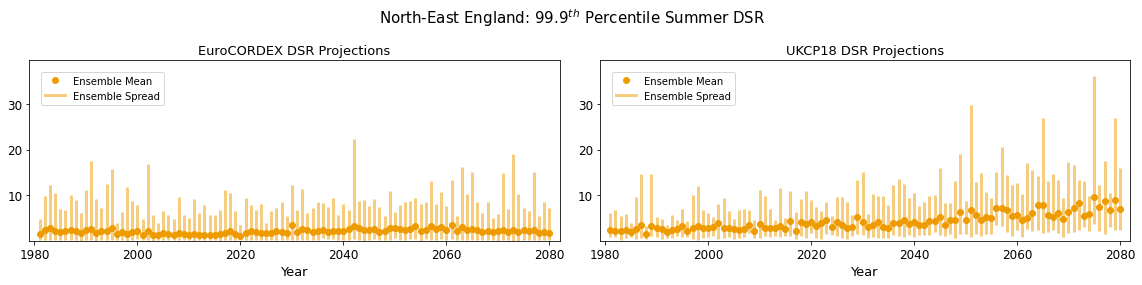

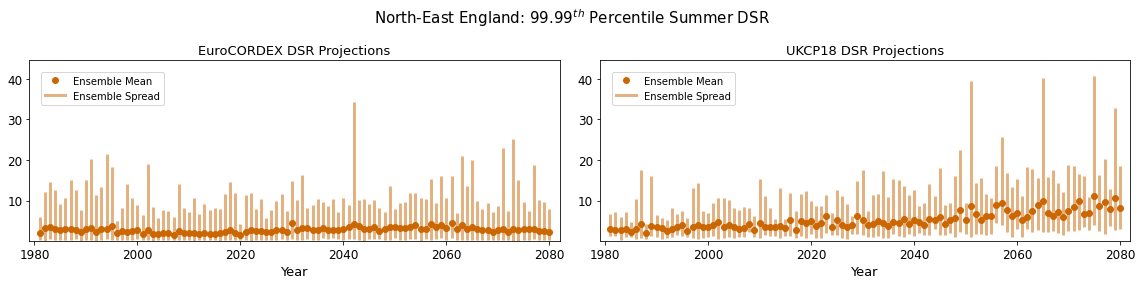

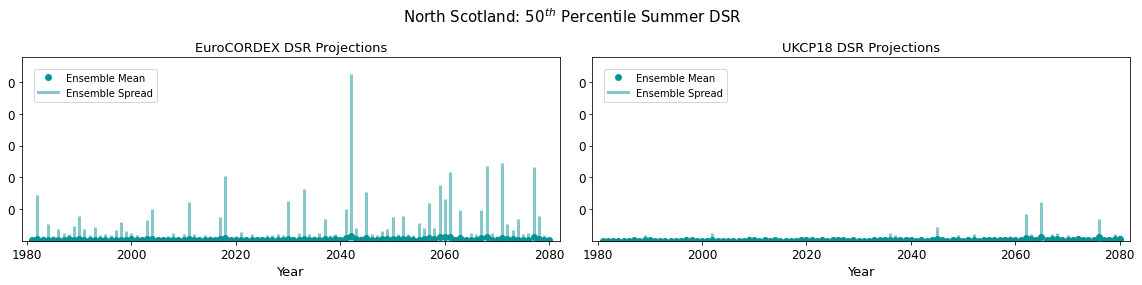

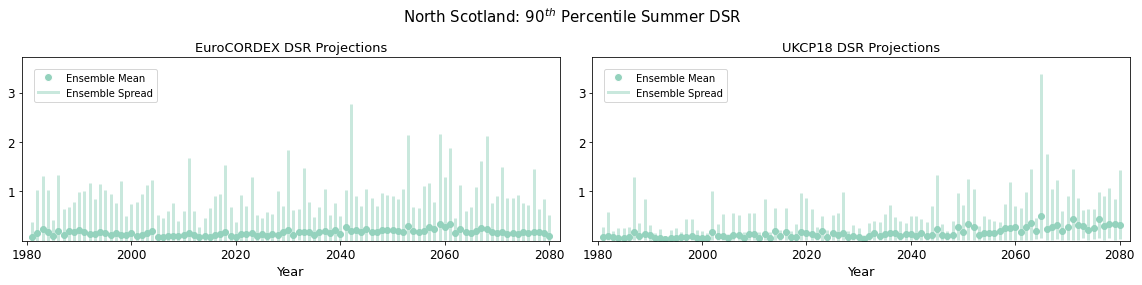

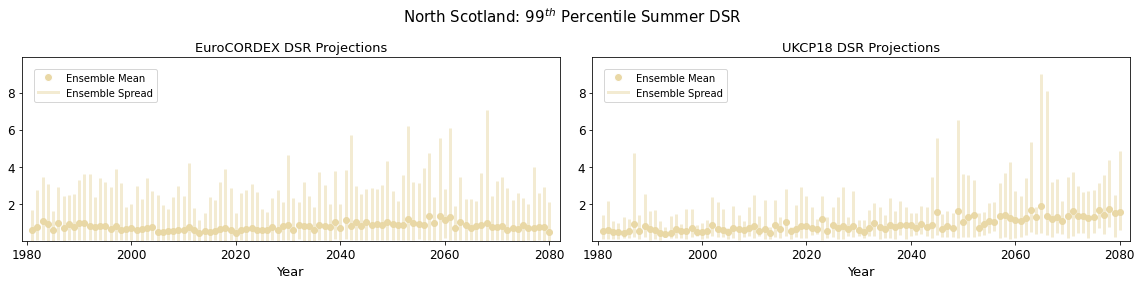

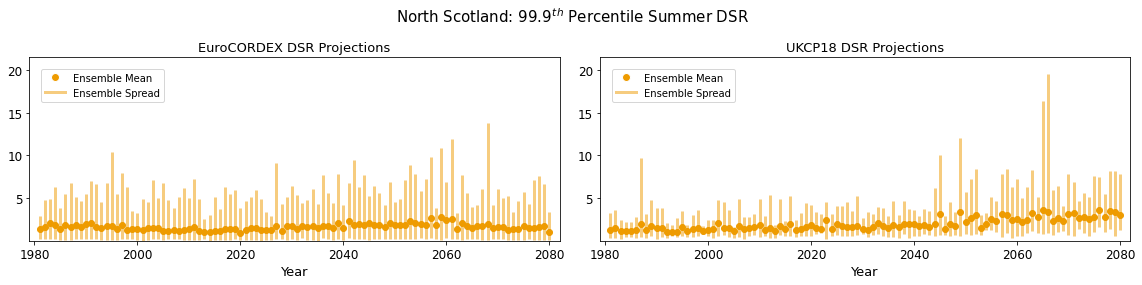

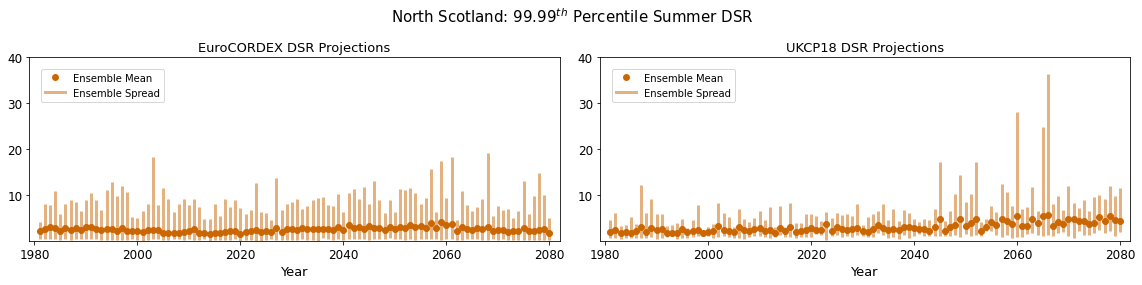

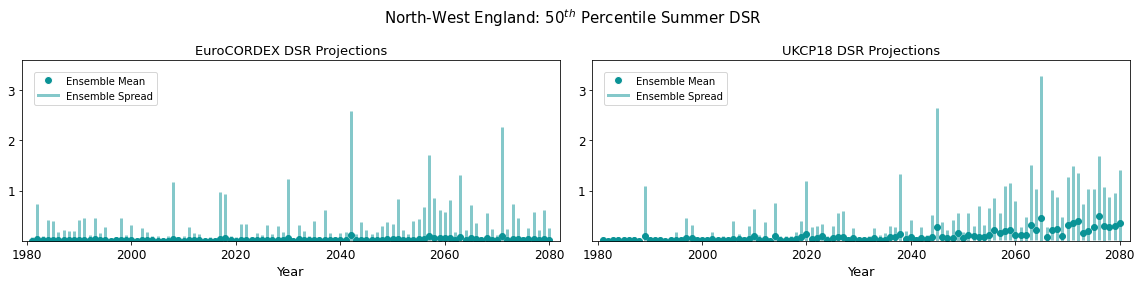

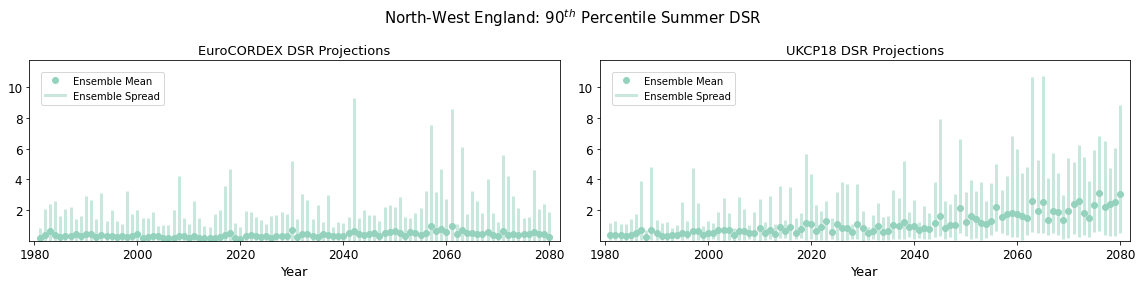

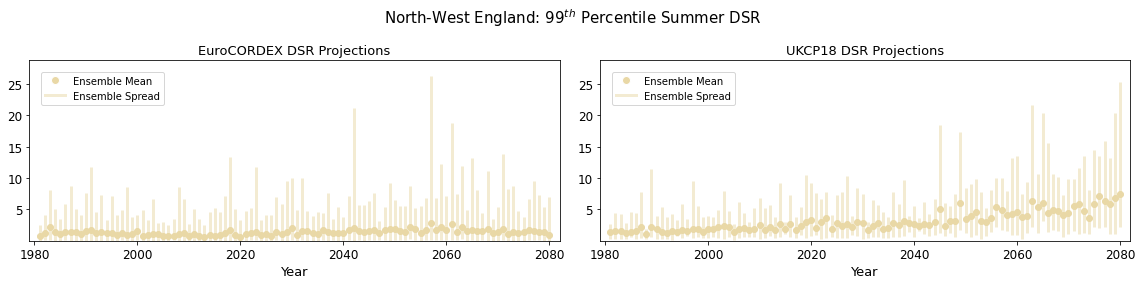

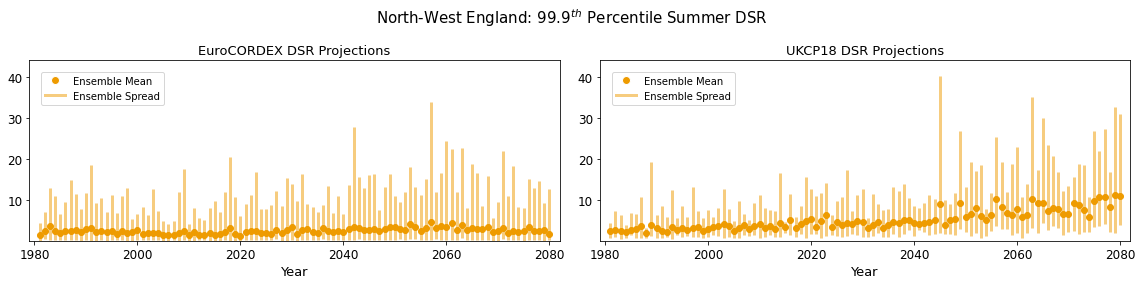

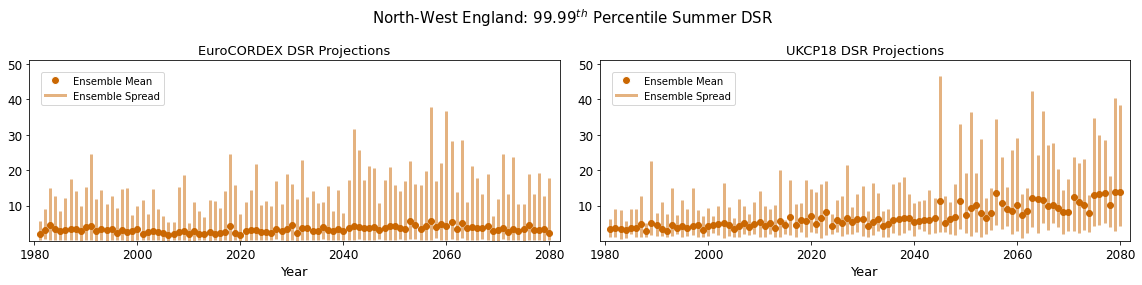

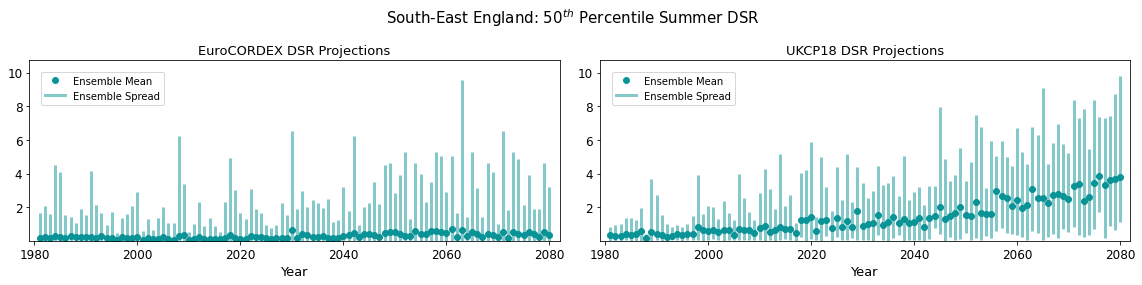

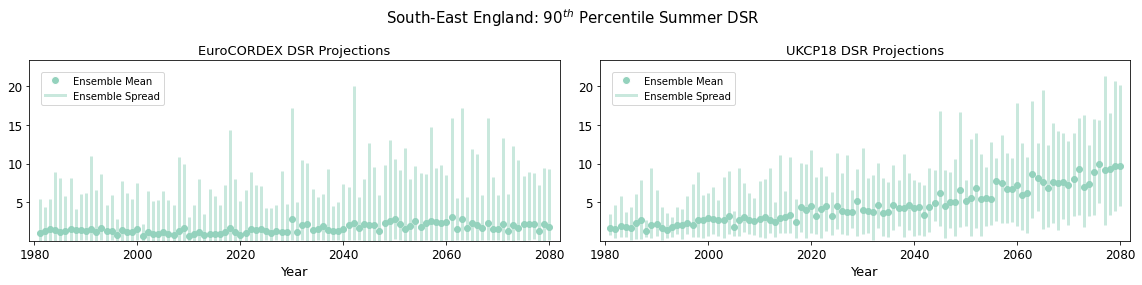

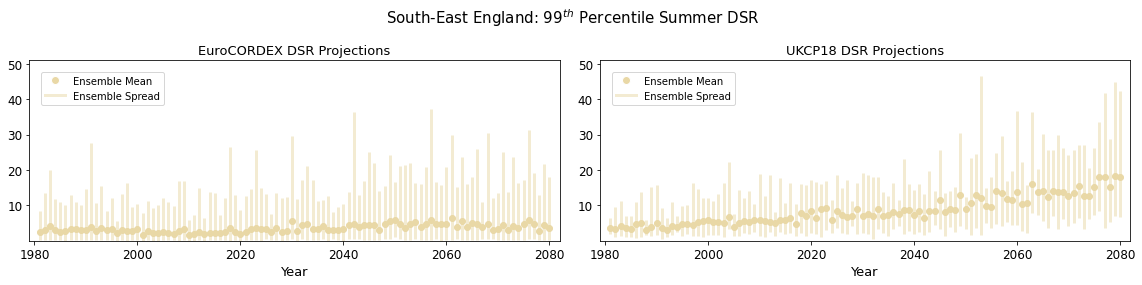

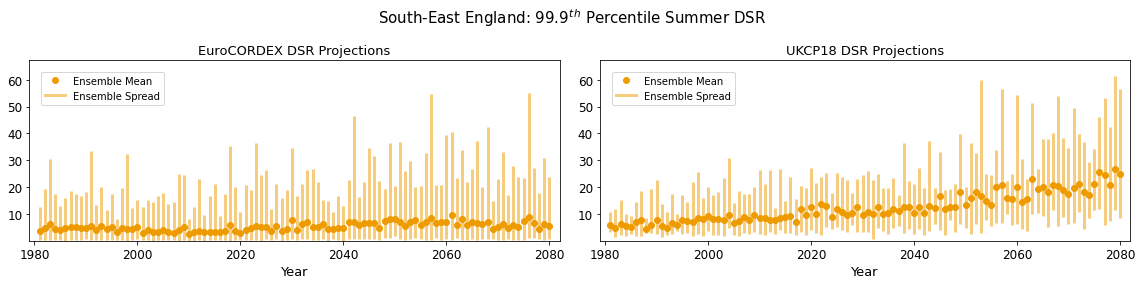

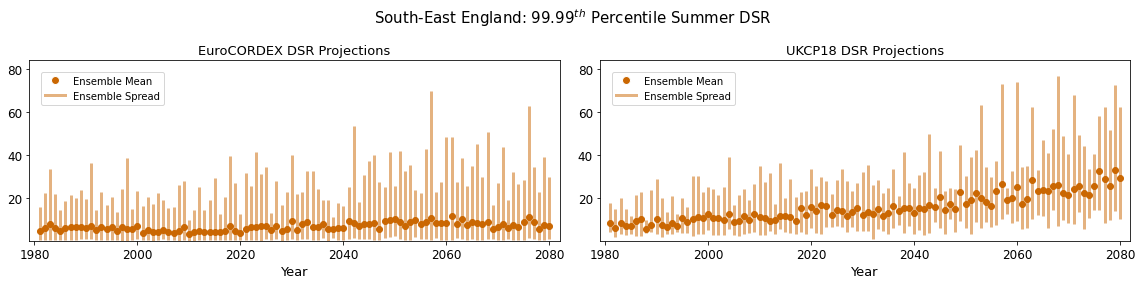

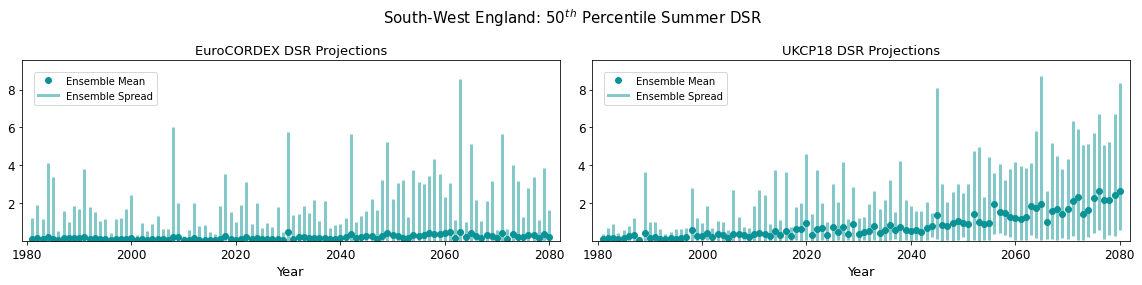

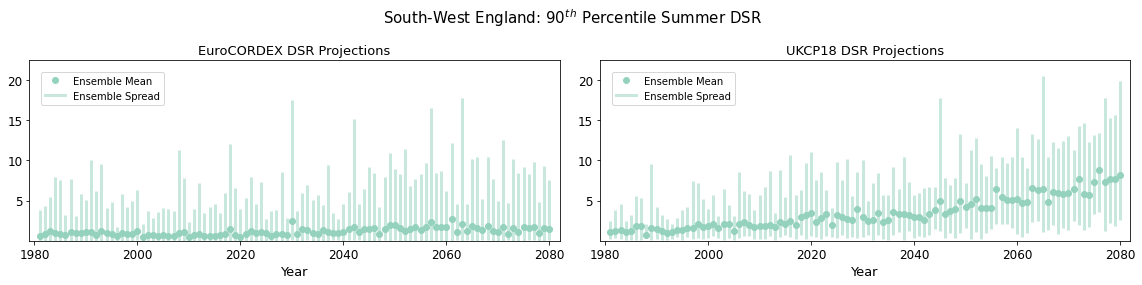

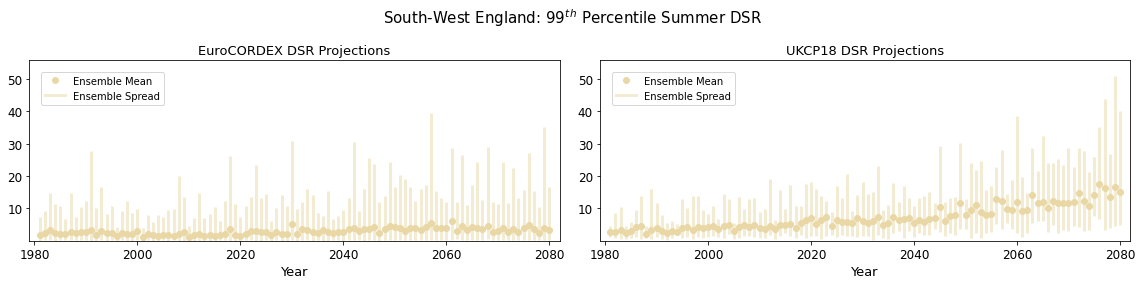

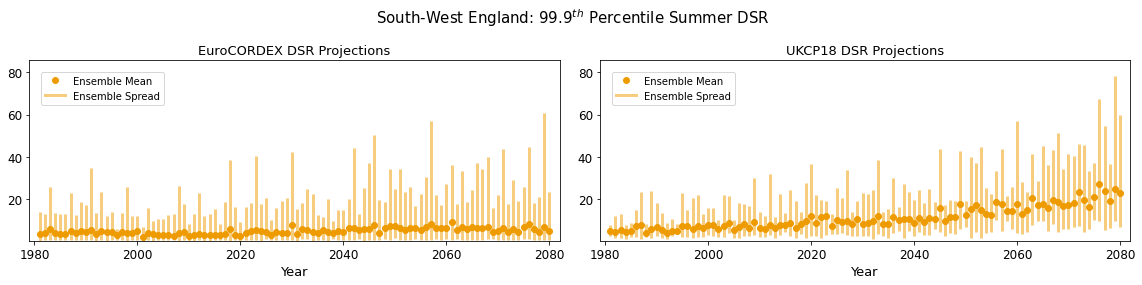

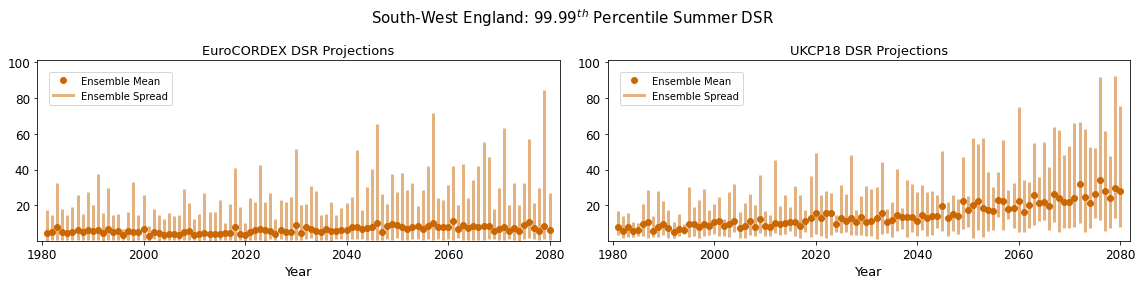

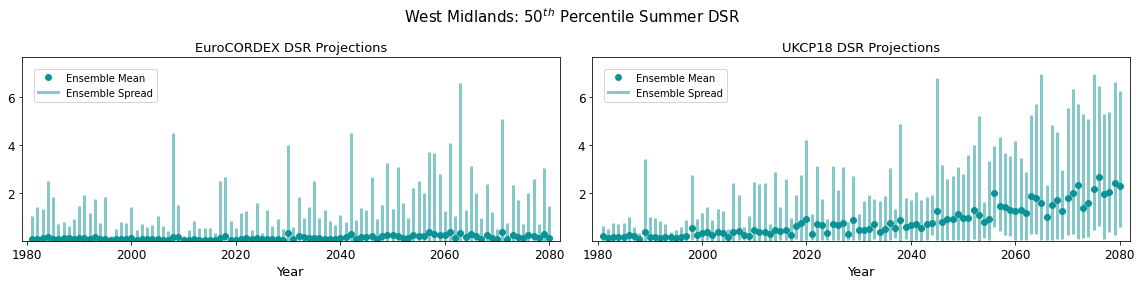

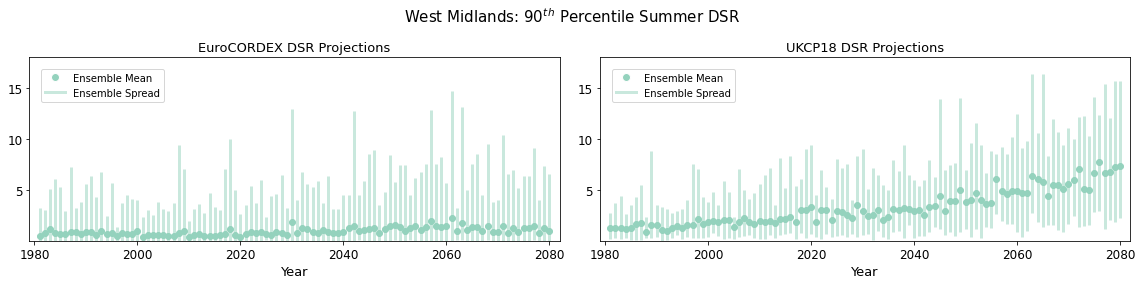

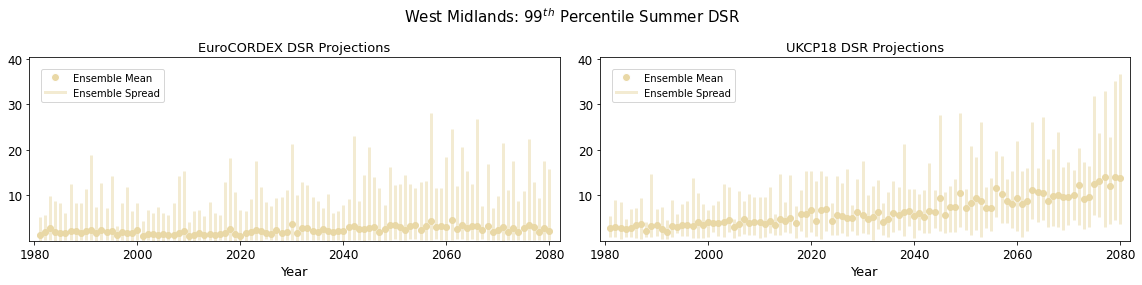

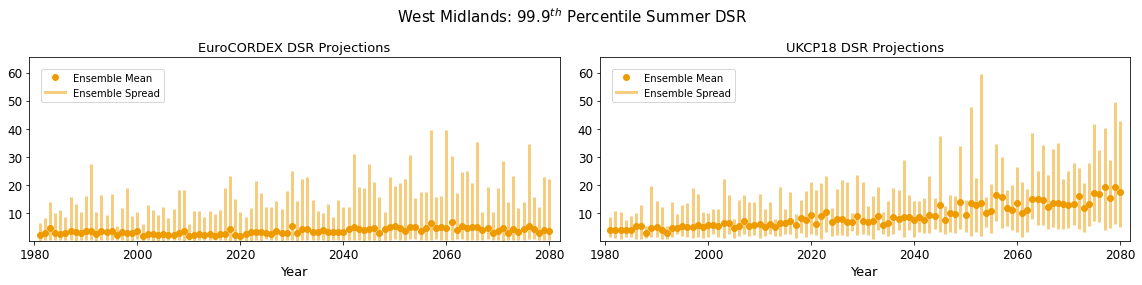

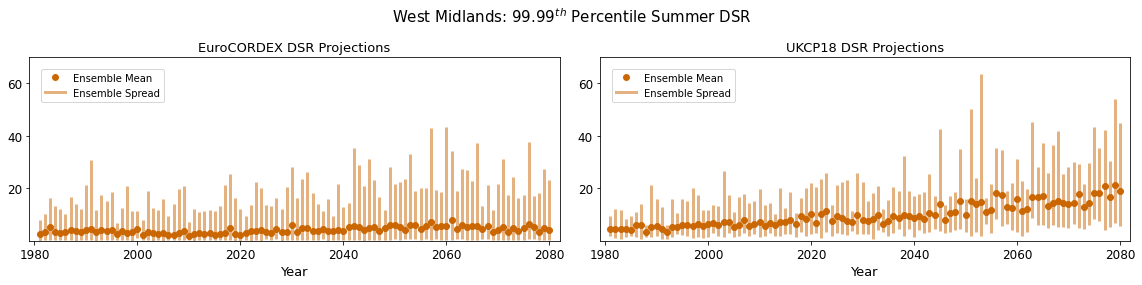

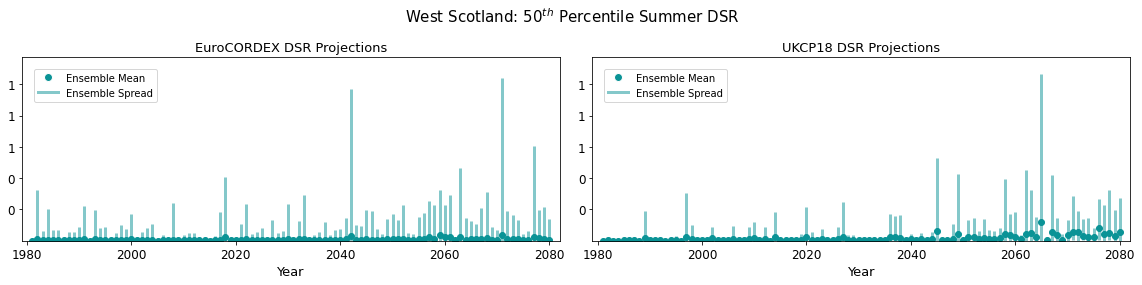

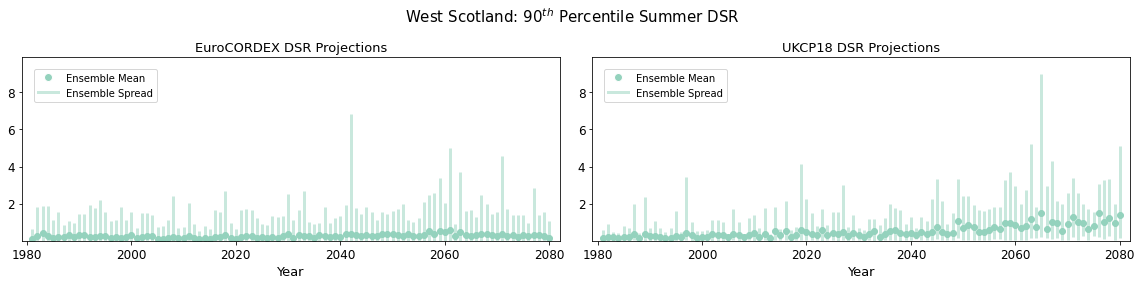

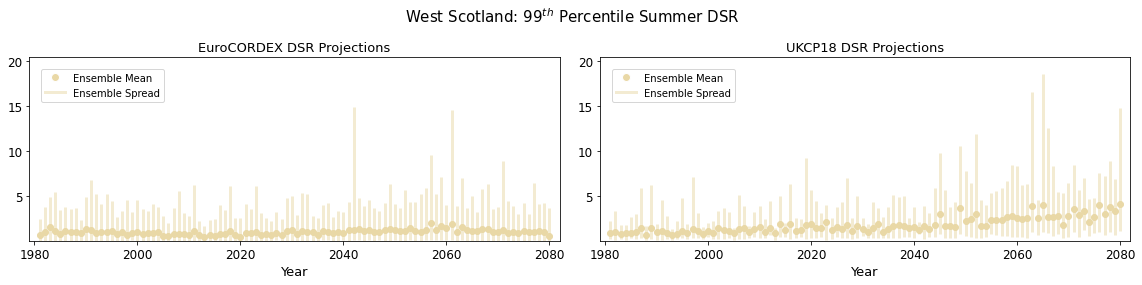

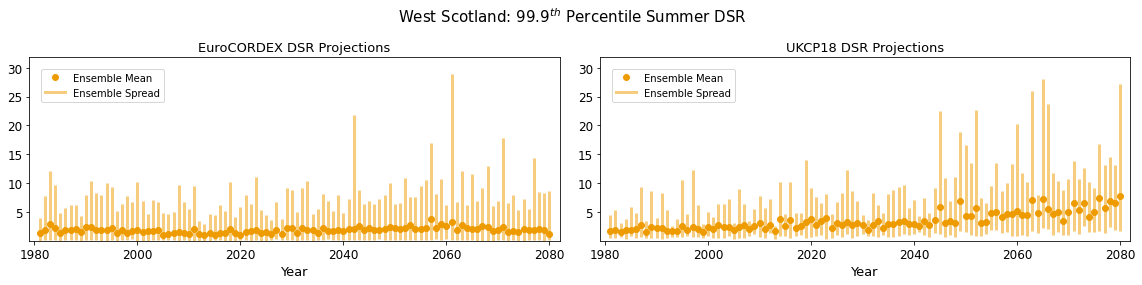

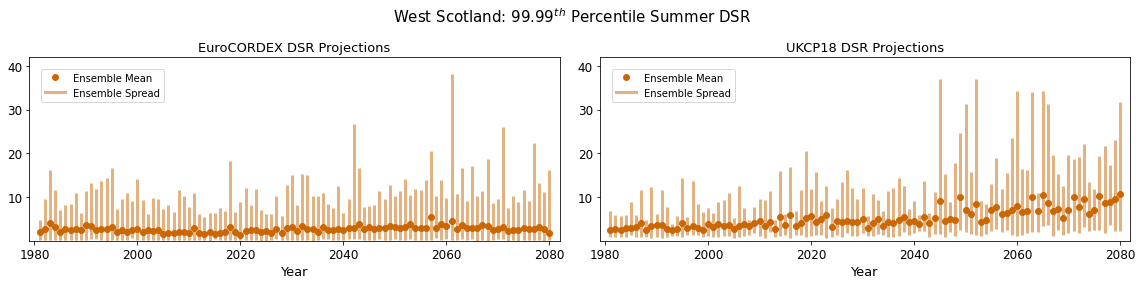

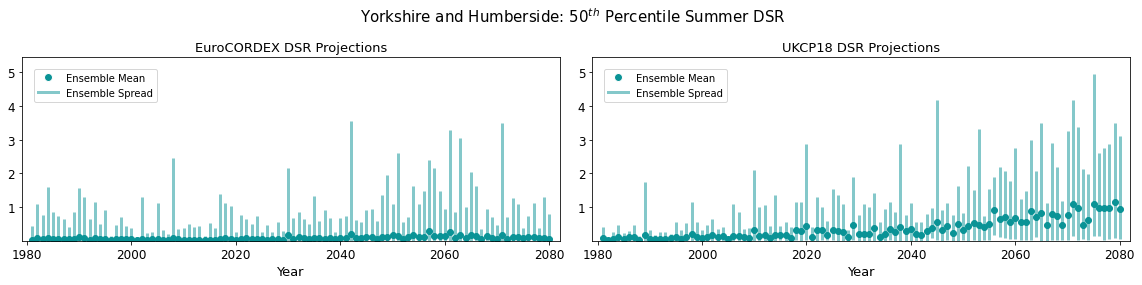

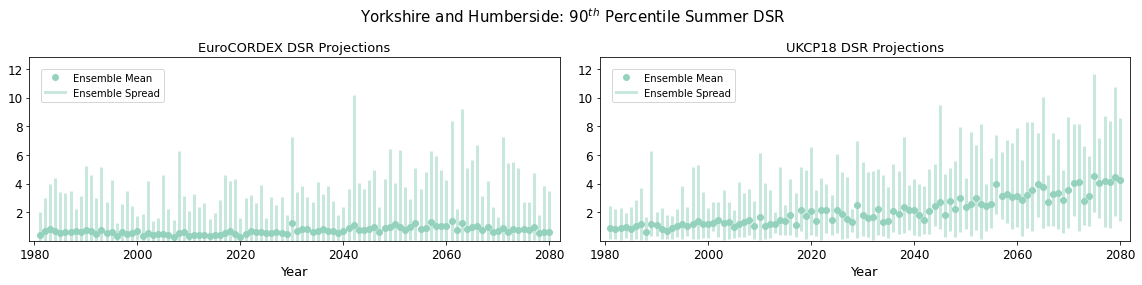

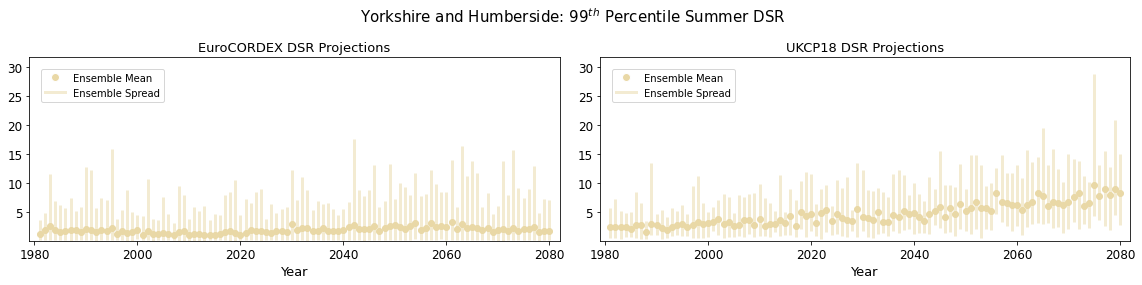

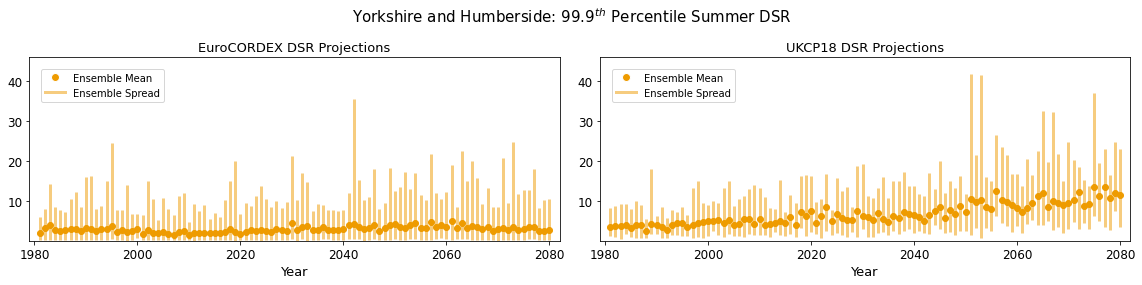

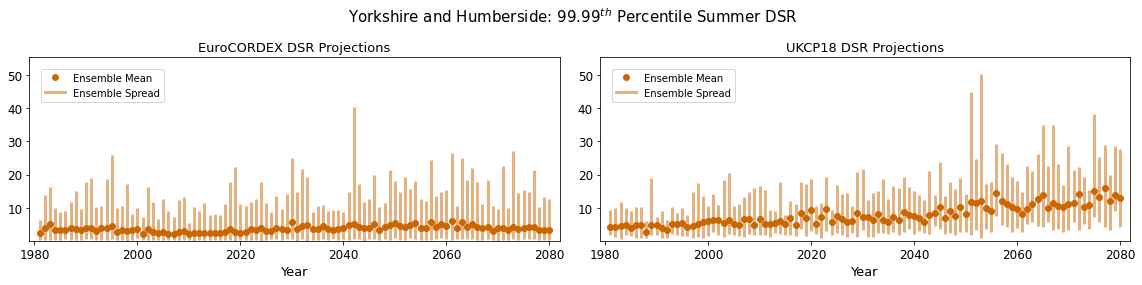

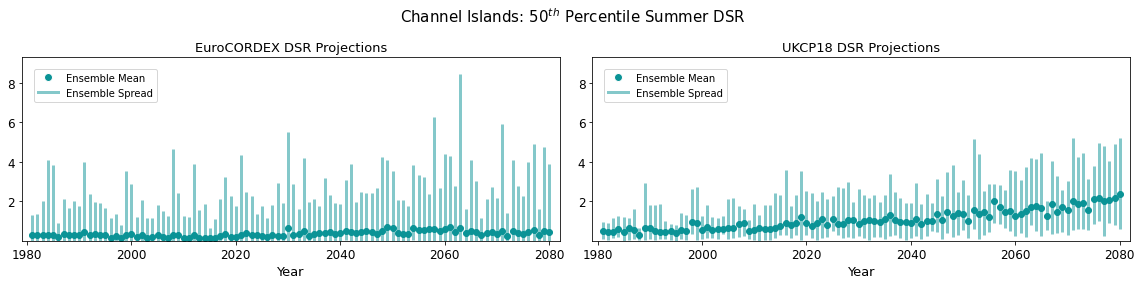

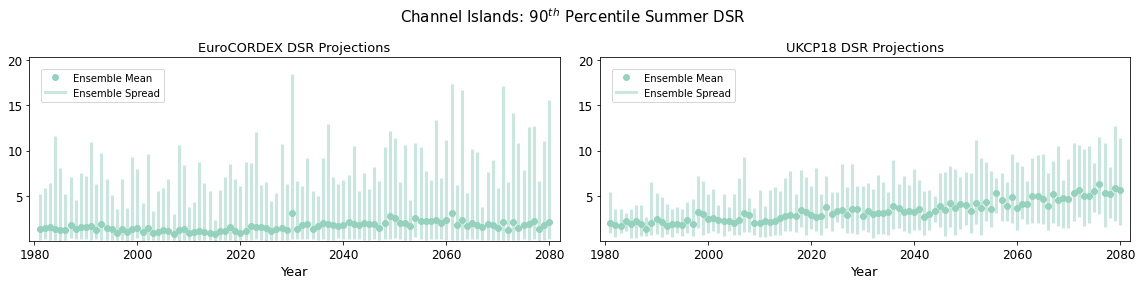

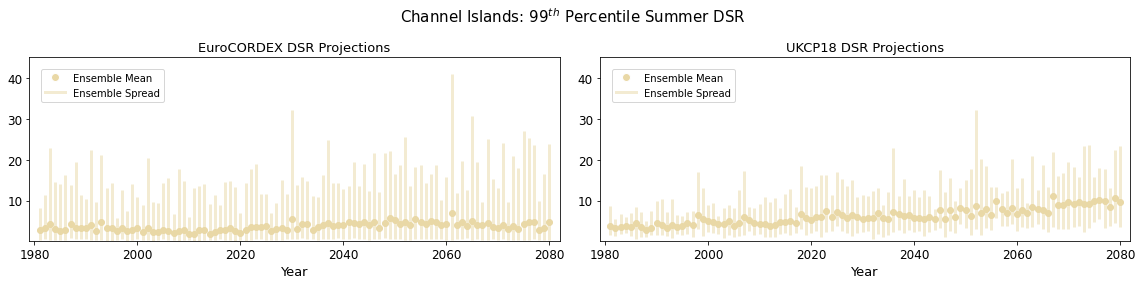

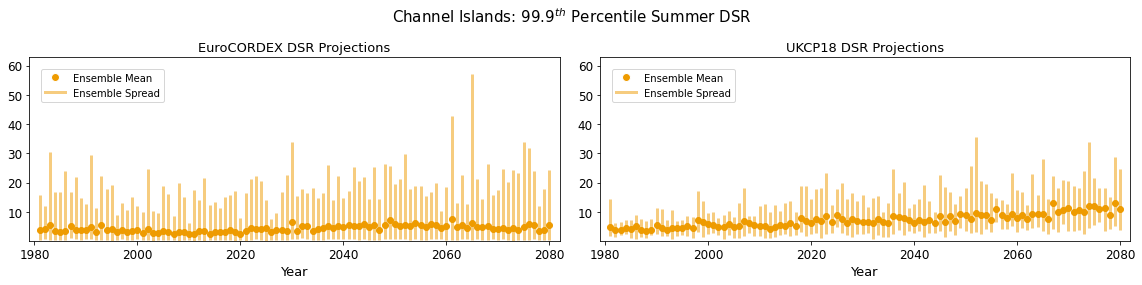

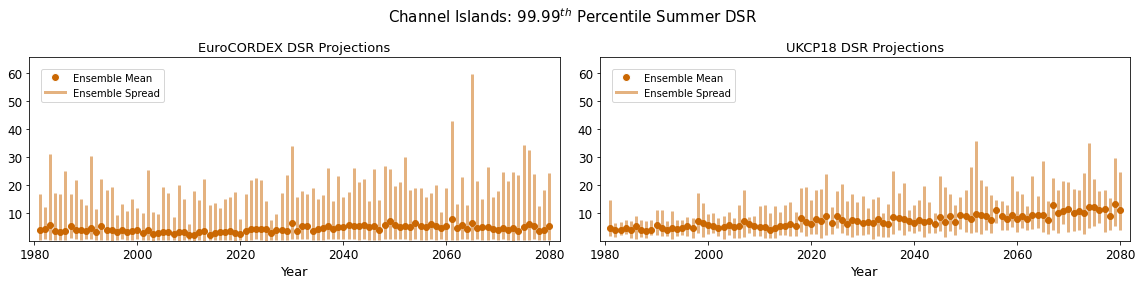

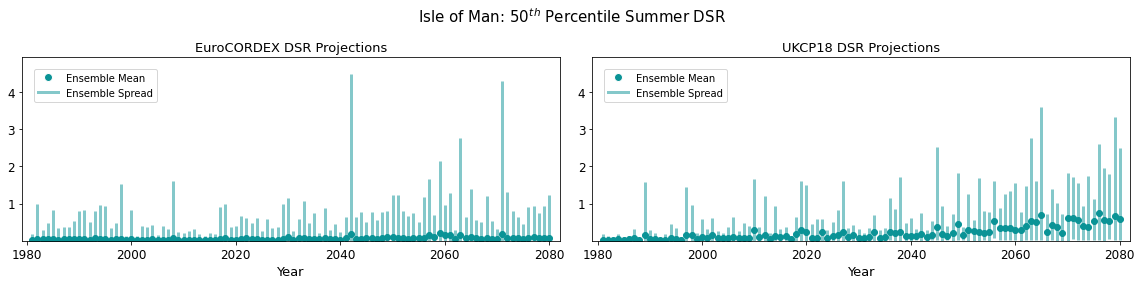

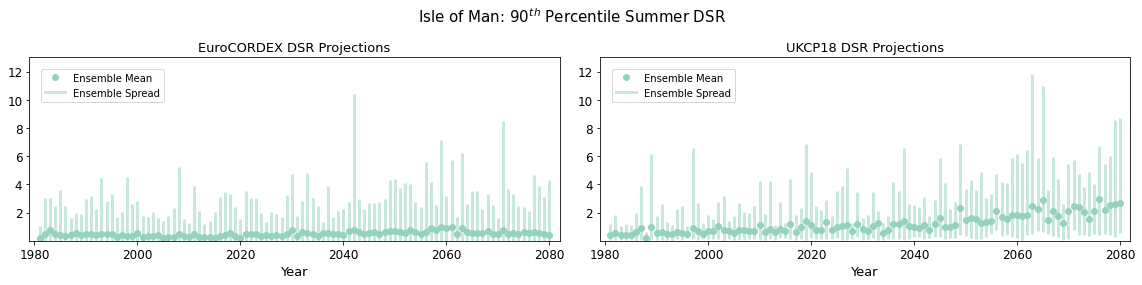

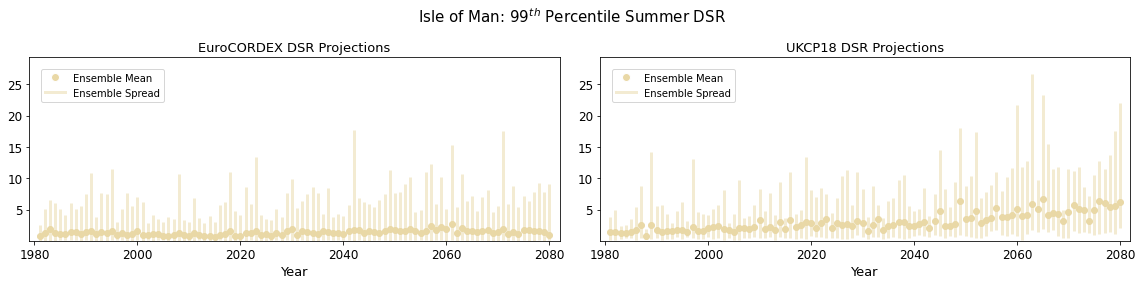

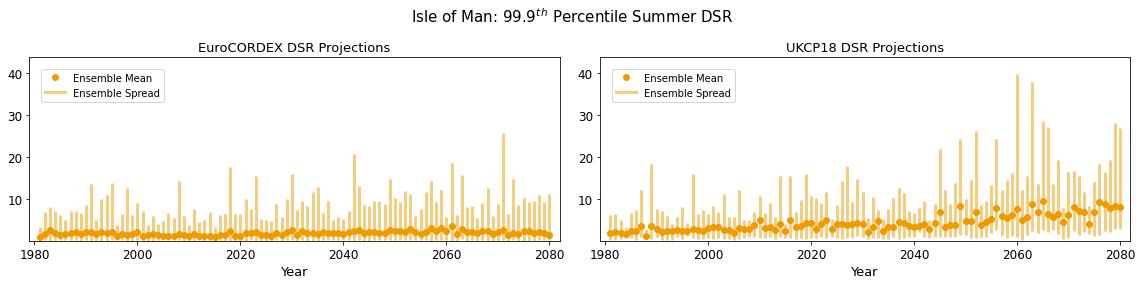

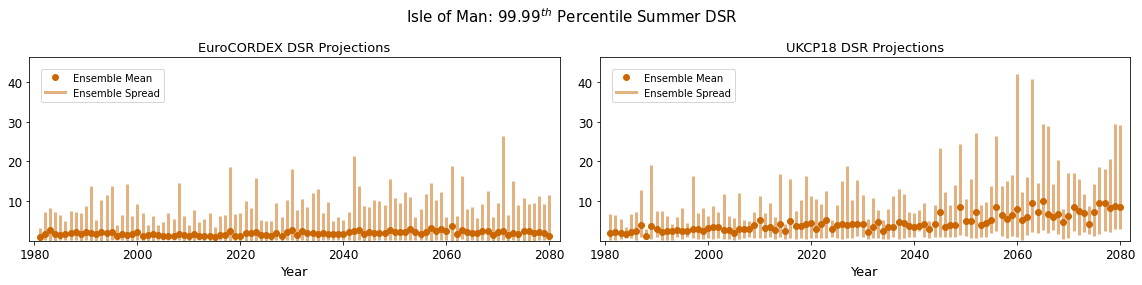

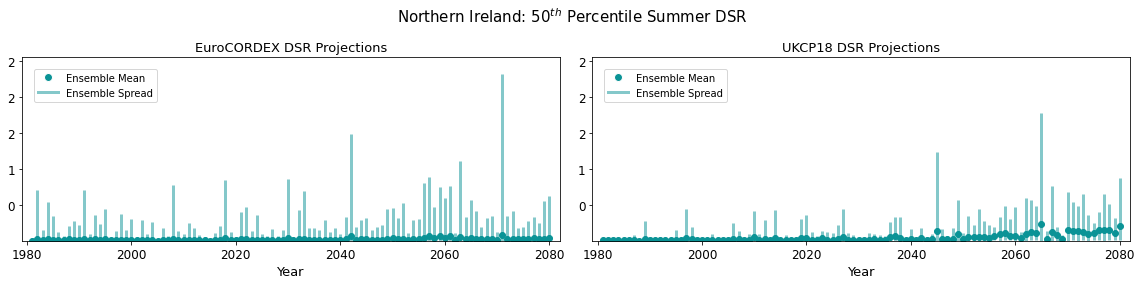

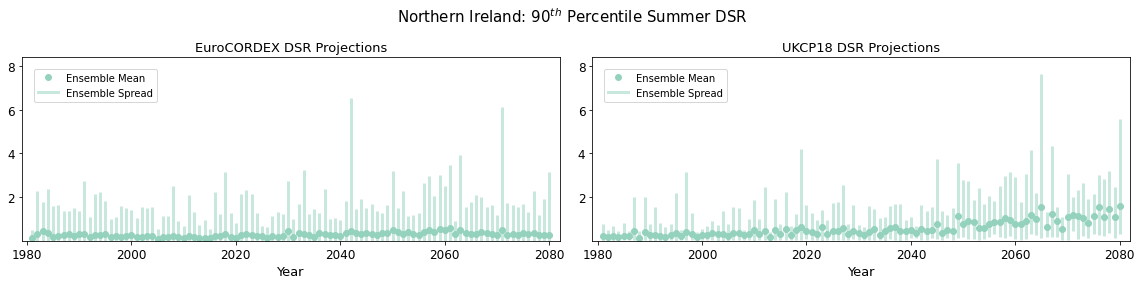

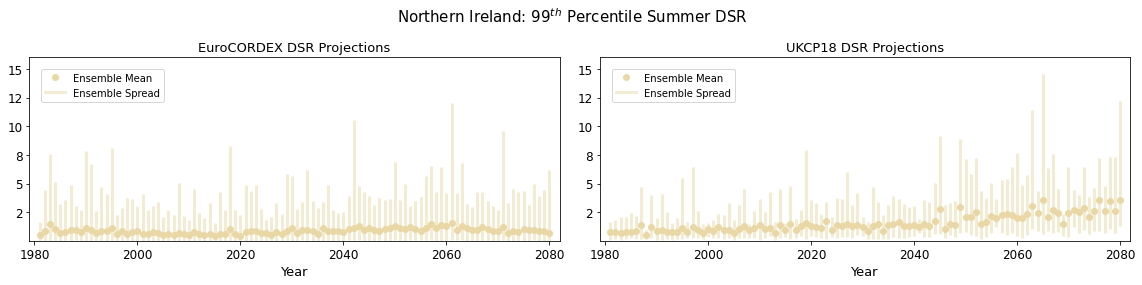

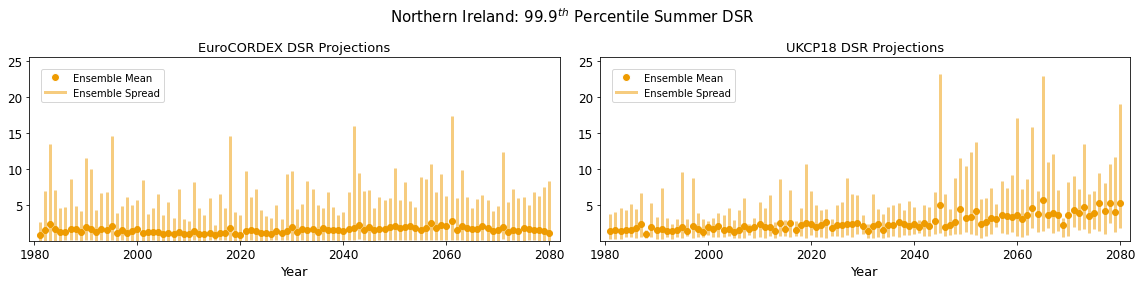

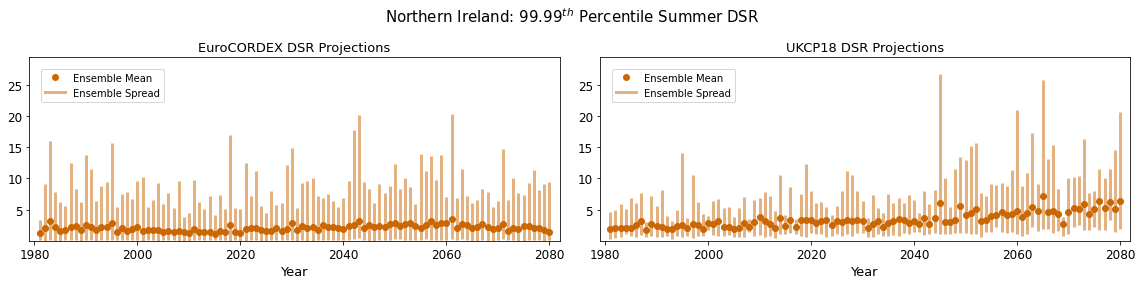

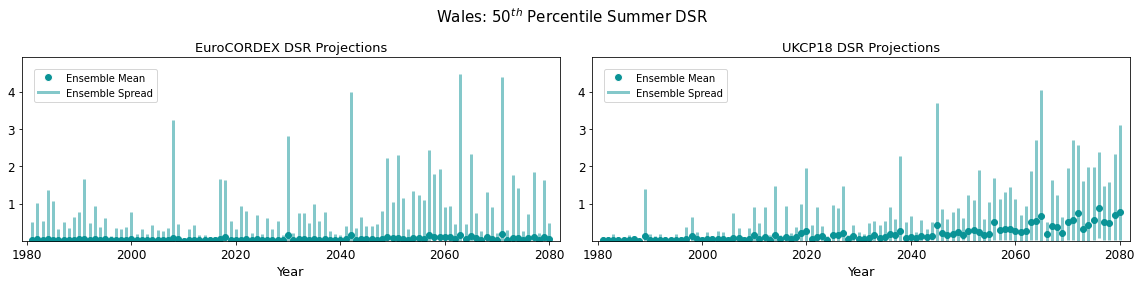

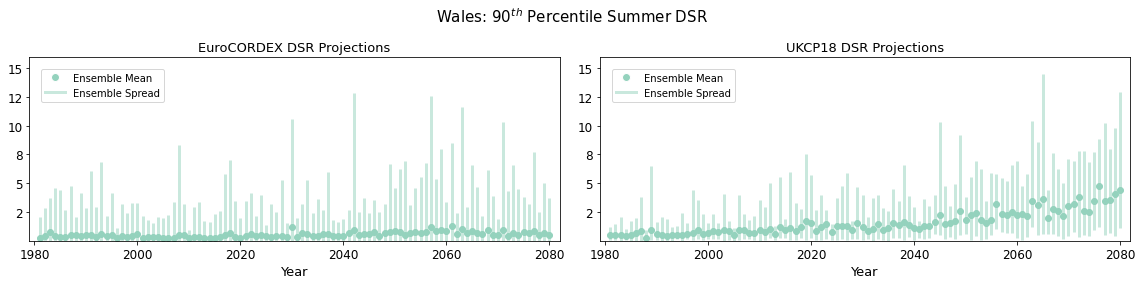

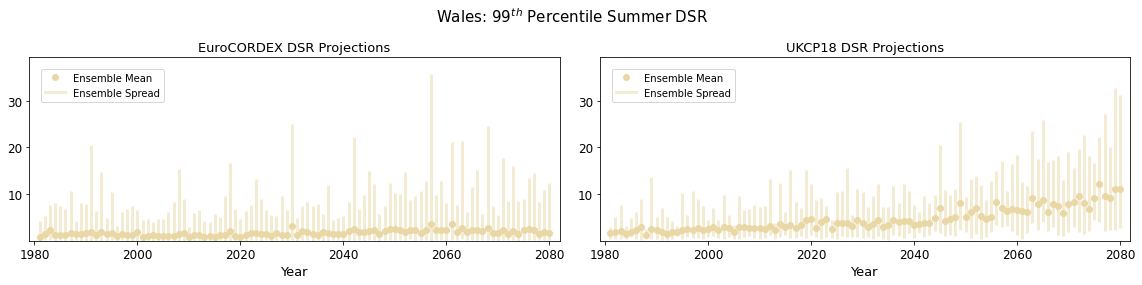

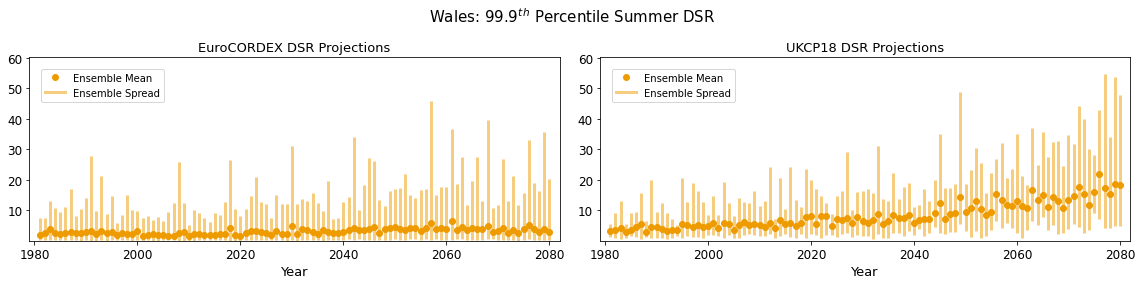

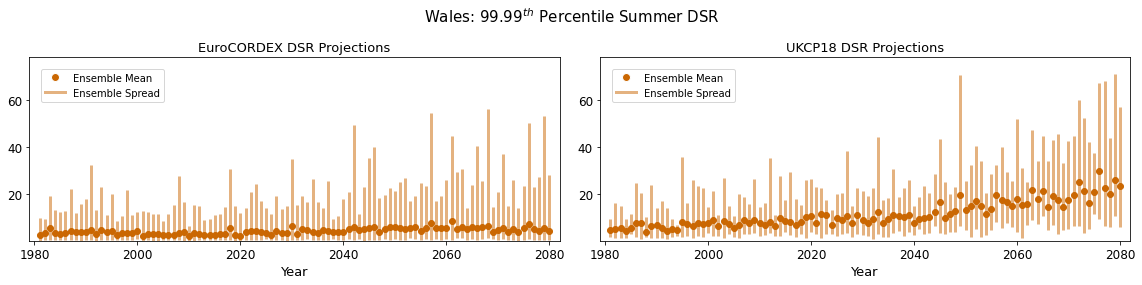

In [6]:
colours =['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
savelbls=['50_pctl','90_pctl','99_pctl','99_9_pctl','99_99_pctl',]
labels = ['50$^t$$^h$','90$^t$$^h$','99$^t$$^h$','99.9$^t$$^h$','99.99$^t$$^h$']
for j in range(17):
    # Loading data:
    for k in range(5):
        cordex_data = np.load('/home/theo/outdata/2.4.outdata/dsr_cordex_data.npy')[:,j,:,k]
        ukcp18_data = np.load('/home/theo/outdata/2.4.outdata/dsr_ukcp18_data.npy')[:,j,:,k]

        # Making dates:
        dates = np.array([1981 + i for i in range(100)])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            fig,ax = plt.subplots(1,2)
            fig.set_figheight(4)
            fig.set_figwidth(16)
            fig.suptitle(f'{ids[j]}: {labels[k]} Percentile Summer DSR',fontsize=15)

            
            # Plotting CORDEX:
            ax[0].plot(dates, np.nanmean(cordex_data,axis = 0),'o', color=colours[k])
            ax[0].errorbar(dates, np.nanmean(cordex_data,axis = 0),
                         yerr=np.stack((np.nanmean(cordex_data,axis = 0) - np.nanmin(cordex_data,axis = 0),
                                        np.nanmax(cordex_data,axis = 0) - np.nanmean(cordex_data,axis = 0))), 
                         fmt='', color=colours[k], ecolor=colours[k], alpha=0.5,
                         elinewidth=3, capsize=0,ls='none')
            ax[0].set_title(f'EuroCORDEX DSR Projections',fontsize=13)
            handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
                       mpl.lines.Line2D([0], [0], color=colours[k], linewidth=3, linestyle='-',alpha=0.5)]
            ax[0].legend(handles,['Ensemble Mean','Ensemble Spread'],loc=2,borderaxespad=1.2)
            ax[0].set_xlabel('Year',fontsize=13)
            ax[0].tick_params(axis='both', which='major', labelsize=12)
            ax[0].margins(x=0.02)
            ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
            ax[0].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))
            
            

            # Plotting UKCP18:
            ax[1].plot(dates, np.nanmean(ukcp18_data,axis = 0),'o', color=colours[k])
            ax[1].errorbar(dates, np.nanmean(ukcp18_data,axis = 0),
                         yerr=np.stack((np.nanmean(ukcp18_data,axis = 0) - np.nanmin(ukcp18_data,axis = 0),
                                        np.nanmax(ukcp18_data,axis = 0) - np.nanmean(ukcp18_data,axis = 0))), 
                         fmt='', color=colours[k], ecolor=colours[k], alpha=0.5,
                         elinewidth=3, capsize=0,ls='none')
            ax[1].set_title(f'UKCP18 DSR Projections',fontsize=13)
            handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[k], markersize=8),
                       mpl.lines.Line2D([0], [0], color=colours[k], linewidth=3, linestyle='-',alpha=0.5)]
            ax[1].legend(handles,['Ensemble Mean','Ensemble Spread'],loc=2,borderaxespad=1.2)
            ax[1].set_xlabel('Year',fontsize=13)
            ax[1].tick_params(axis='both', which='major', labelsize=12)
            ax[1].margins(x=0.02)
            ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
            ax[1].set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))
            plt.tight_layout()
            plt.savefig(f'/home/theo/final_images/2.4.images/summer_dsr_{savelbls[k]}_{save_ids[j]}')

#### Checking Newest FWI:

In [ ]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
n = 1 

In [ ]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
dates = np.array([1981 + i for i in range(100)])
old_cordex_data = np.empty((17,100,5))

fwi = np.load(f'/data/met/fwi/ukcordex_new_fwi_{n}.npy')
tas_data  = xarray.open_dataset(directories[n-1] + tas_files[n-1], engine = "netcdf4")
try:
    years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
    months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
except:
    years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
    months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
del tas_data
for j in range(17):
    mask = (region_mask == j).astype(int)


    for k in range(100):
        summer_indices = np.array([])
        year_inds = np.where(years == 1981+k)
        summer_inds=np.concatenate((np.where(months == 6)[0],
                                    np.where(months == 7)[0],
                                    np.where(months == 8)[0]),
                                    axis = 0)
        summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)
        masked_fwi = np.einsum('ijk,jk->ijk', fwi[0,summer_indices,:,:], mask)
        masked_fwi[masked_fwi == 0] = np.nan
        old_cordex_data[j,k,0] = np.nanpercentile(masked_fwi,50)
        old_cordex_data[j,k,1] = np.nanpercentile(masked_fwi,90)
        old_cordex_data[j,k,2] = np.nanpercentile(masked_fwi,99)
        old_cordex_data[j,k,3] = np.nanpercentile(masked_fwi,99.9)
        old_cordex_data[j,k,4] = np.nanpercentile(masked_fwi,99.99)

        del masked_fwi,summer_indices,summer_inds,year_inds
    del mask
del fwi,years,months

In [ ]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
dates = np.array([1981 + i for i in range(100)])
new_cordex_data = np.empty((17,100,5))

fwi = np.load(f'/data/met/fwi/ukcordex_newest_fwi_{n}.npy')
tas_data  = xarray.open_dataset(directories[n-1] + tas_files[n-1], engine = "netcdf4")
try:
    years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
    months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
except:
    years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
    months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
del tas_data
for j in range(17):
    mask = (region_mask == j).astype(int)


    for k in range(100):
        summer_indices = np.array([])
        year_inds = np.where(years == 1981+k)
        summer_inds=np.concatenate((np.where(months == 6)[0],
                                    np.where(months == 7)[0],
                                    np.where(months == 8)[0]),
                                    axis = 0)
        summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)
        masked_fwi = np.einsum('ijk,jk->ijk', fwi[0,summer_indices,:,:], mask)
        masked_fwi[masked_fwi == 0] = np.nan
        new_cordex_data[j,k,0] = np.nanpercentile(masked_fwi,50)
        new_cordex_data[j,k,1] = np.nanpercentile(masked_fwi,90)
        new_cordex_data[j,k,2] = np.nanpercentile(masked_fwi,99)
        new_cordex_data[j,k,3] = np.nanpercentile(masked_fwi,99.9)
        new_cordex_data[j,k,4] = np.nanpercentile(masked_fwi,99.99)

        del masked_fwi,summer_indices,summer_inds,year_inds
    del mask
del fwi,years,months

In [ ]:
print(np.unique(old_cordex_data-new_cordex_data))

In [ ]:
%run /home/theo/scripts/cordex_debugger.py